In [7]:
import pandas as pd
import numpy as np

import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
import hvplot.pandas

from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Read Data

In [21]:
train = pd.read_csv('home-credit-default-risk/application_train.csv')
test = pd.read_csv('home-credit-default-risk/application_test.csv')
bureau = pd.read_csv("home-credit-default-risk/bureau.csv")
bureau_balance = pd.read_csv("home-credit-default-risk/bureau_balance.csv")
credit_card_balance = pd.read_csv("home-credit-default-risk/credit_card_balance.csv")
installments = pd.read_csv("home-credit-default-risk/installments_payments.csv")
POS_CASH_balance = pd.read_csv("home-credit-default-risk/POS_CASH_balance.csv")
previous = pd.read_csv("home-credit-default-risk/previous_application.csv")

In [9]:
train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR   
0      100002       1         Cash loans           M            N  \
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY   
0               Y             0          202500.0    406597.5      24700.5  \
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21   
0  ...                 0                0                0                0  \
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY   
0                        0.0                       0.0  \
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON   
0                         0.0                        0.0  \
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [10]:
train.shape

(307511, 122)

In [11]:
test.shape

(48744, 121)

## EDA

In [12]:
## Examine the Distribution of the Target Column
train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

<Axes: xlabel='TARGET'>

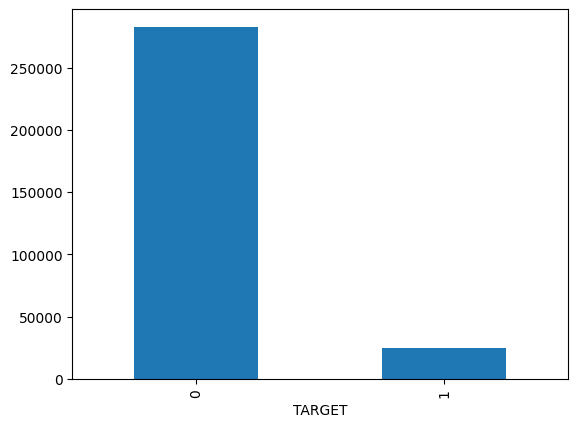

In [16]:
train['TARGET'].value_counts().plot(kind = 'bar')

In [17]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
         # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [19]:
missing_values_table(train).head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_AVG              210199               68.4
FLOORSMIN_MODE                    208642               67.8
FLOORSMIN_MEDI                    208642               67.8
FLOORSMIN_AVG                     208642               67.8
YEARS_BUILD_MODE                  204488               66.5
YEARS_BUILD_MEDI                  204488               66.5
YEARS_BUILD_AVG                   204488               66.5
OWN_CAR_AGE                       202929               66.0
LANDAREA_AVG                      182590               59.4
LANDAREA_MEDI                     182590               59.4
LANDAREA_MODE                     182590               59.4

Solution : 1. imputation 2. use model handling NA: XGBoost 3. fill and analyze one by one

In [20]:
train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [27]:
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

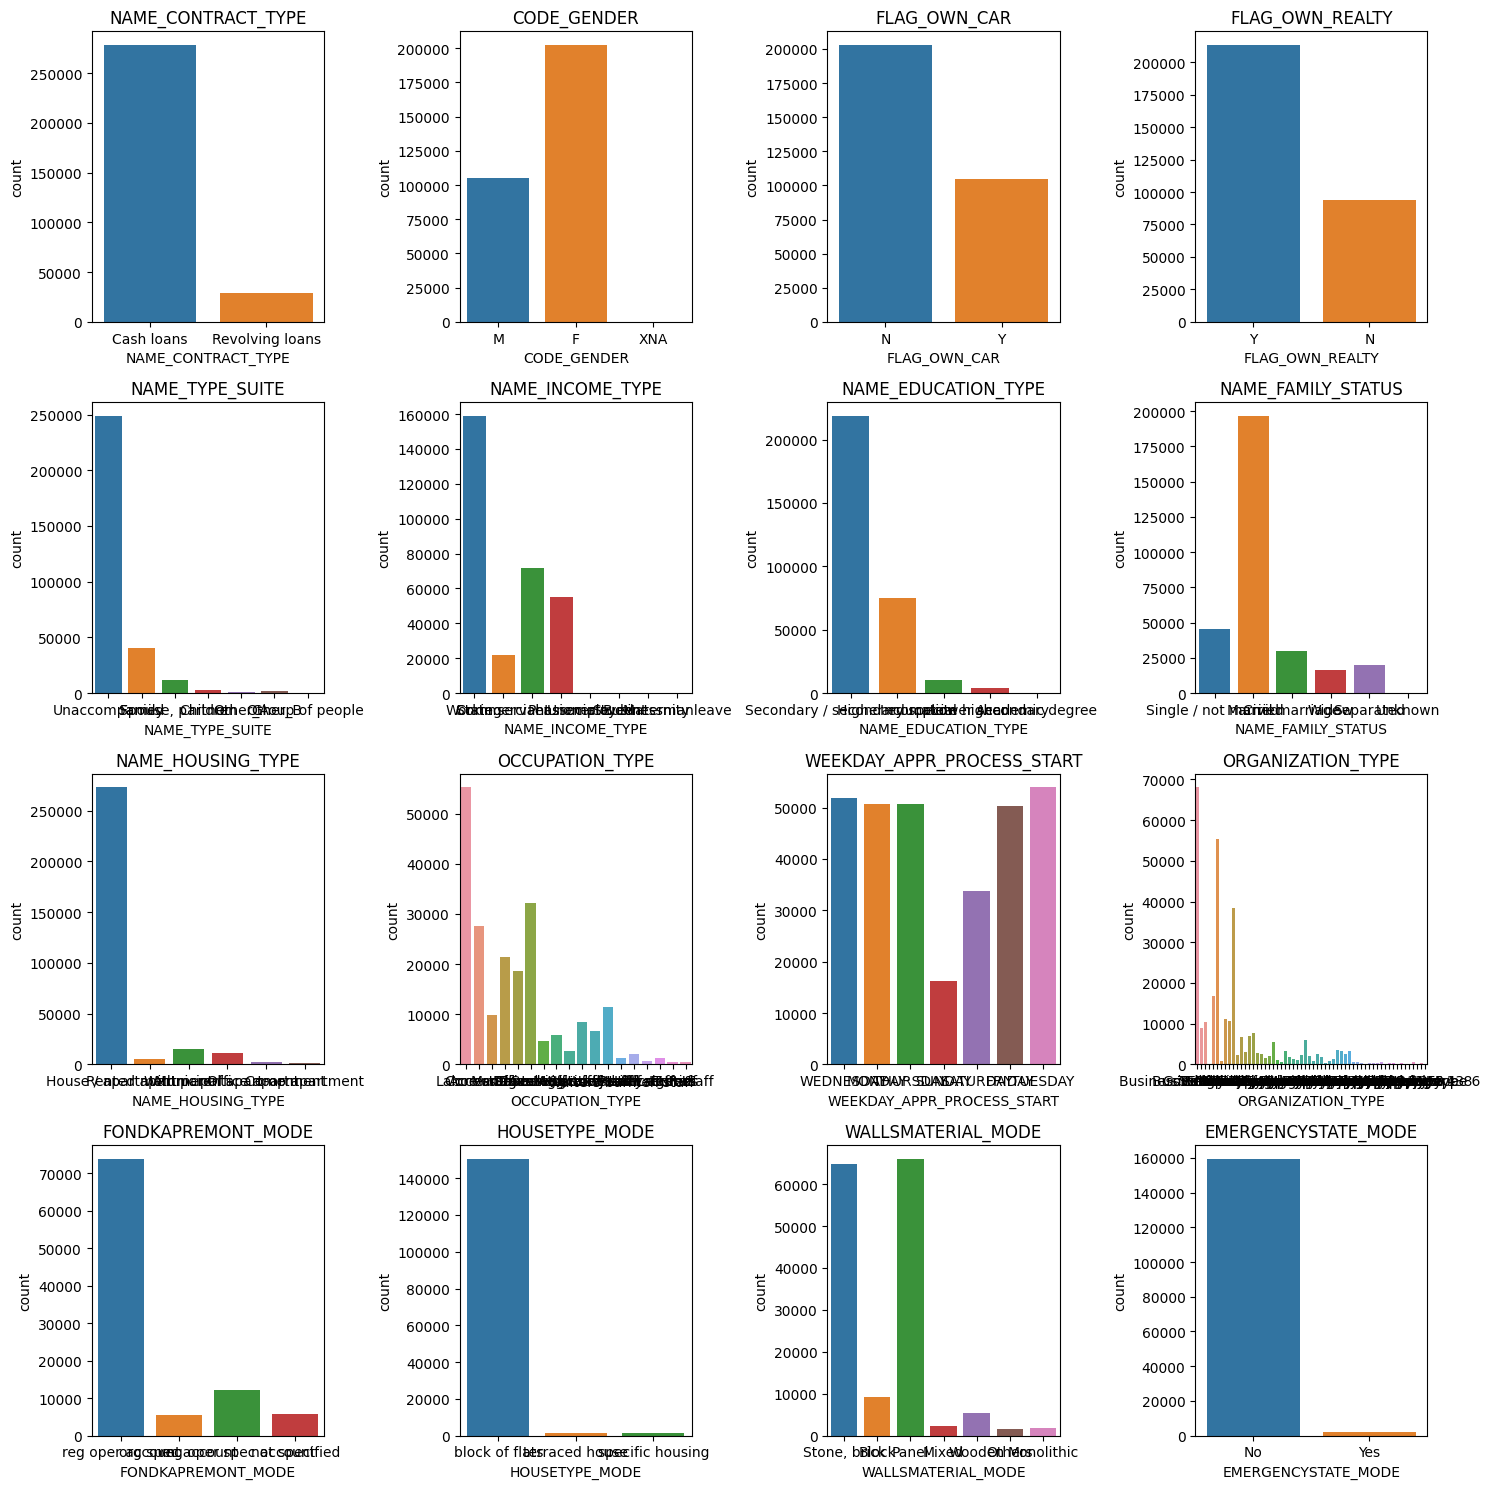

In [28]:
f, axes = plt.subplots(nrows = 4, ncols=4, figsize=(15,15))
axess = axes.flatten()

i = 0
for column in train.select_dtypes('object').columns:
    sns.countplot(x = column,data = train, ax=axess[i])
    axess[i].set_title(column)
    i+=1

    
plt.tight_layout()
plt.show()

In [25]:
## Encoding Categorical Variables

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train:
    if train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if train[col].nunique() <= 2:
            # Transform both training and testing data
            train[col] = le.fit_transform(train[col])
            test[col] = le.transform(test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

4 columns were label encoded.


In [30]:
train['OCCUPATION_TYPE'].unique()

array(['Laborers', 'Core staff', 'Accountants', 'Managers', nan,
       'Drivers', 'Sales staff', 'Cleaning staff', 'Cooking staff',
       'Private service staff', 'Medicine staff', 'Security staff',
       'High skill tech staff', 'Waiters/barmen staff',
       'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff',
       'HR staff'], dtype=object)

In [12]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (307511, 246)
Testing Features shape:  (48744, 242)


In [13]:
train_labels = train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
train, test = train.align(test, join = 'inner', axis = 1)

# Add the target back in
train['TARGET'] = train_labels

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 242)


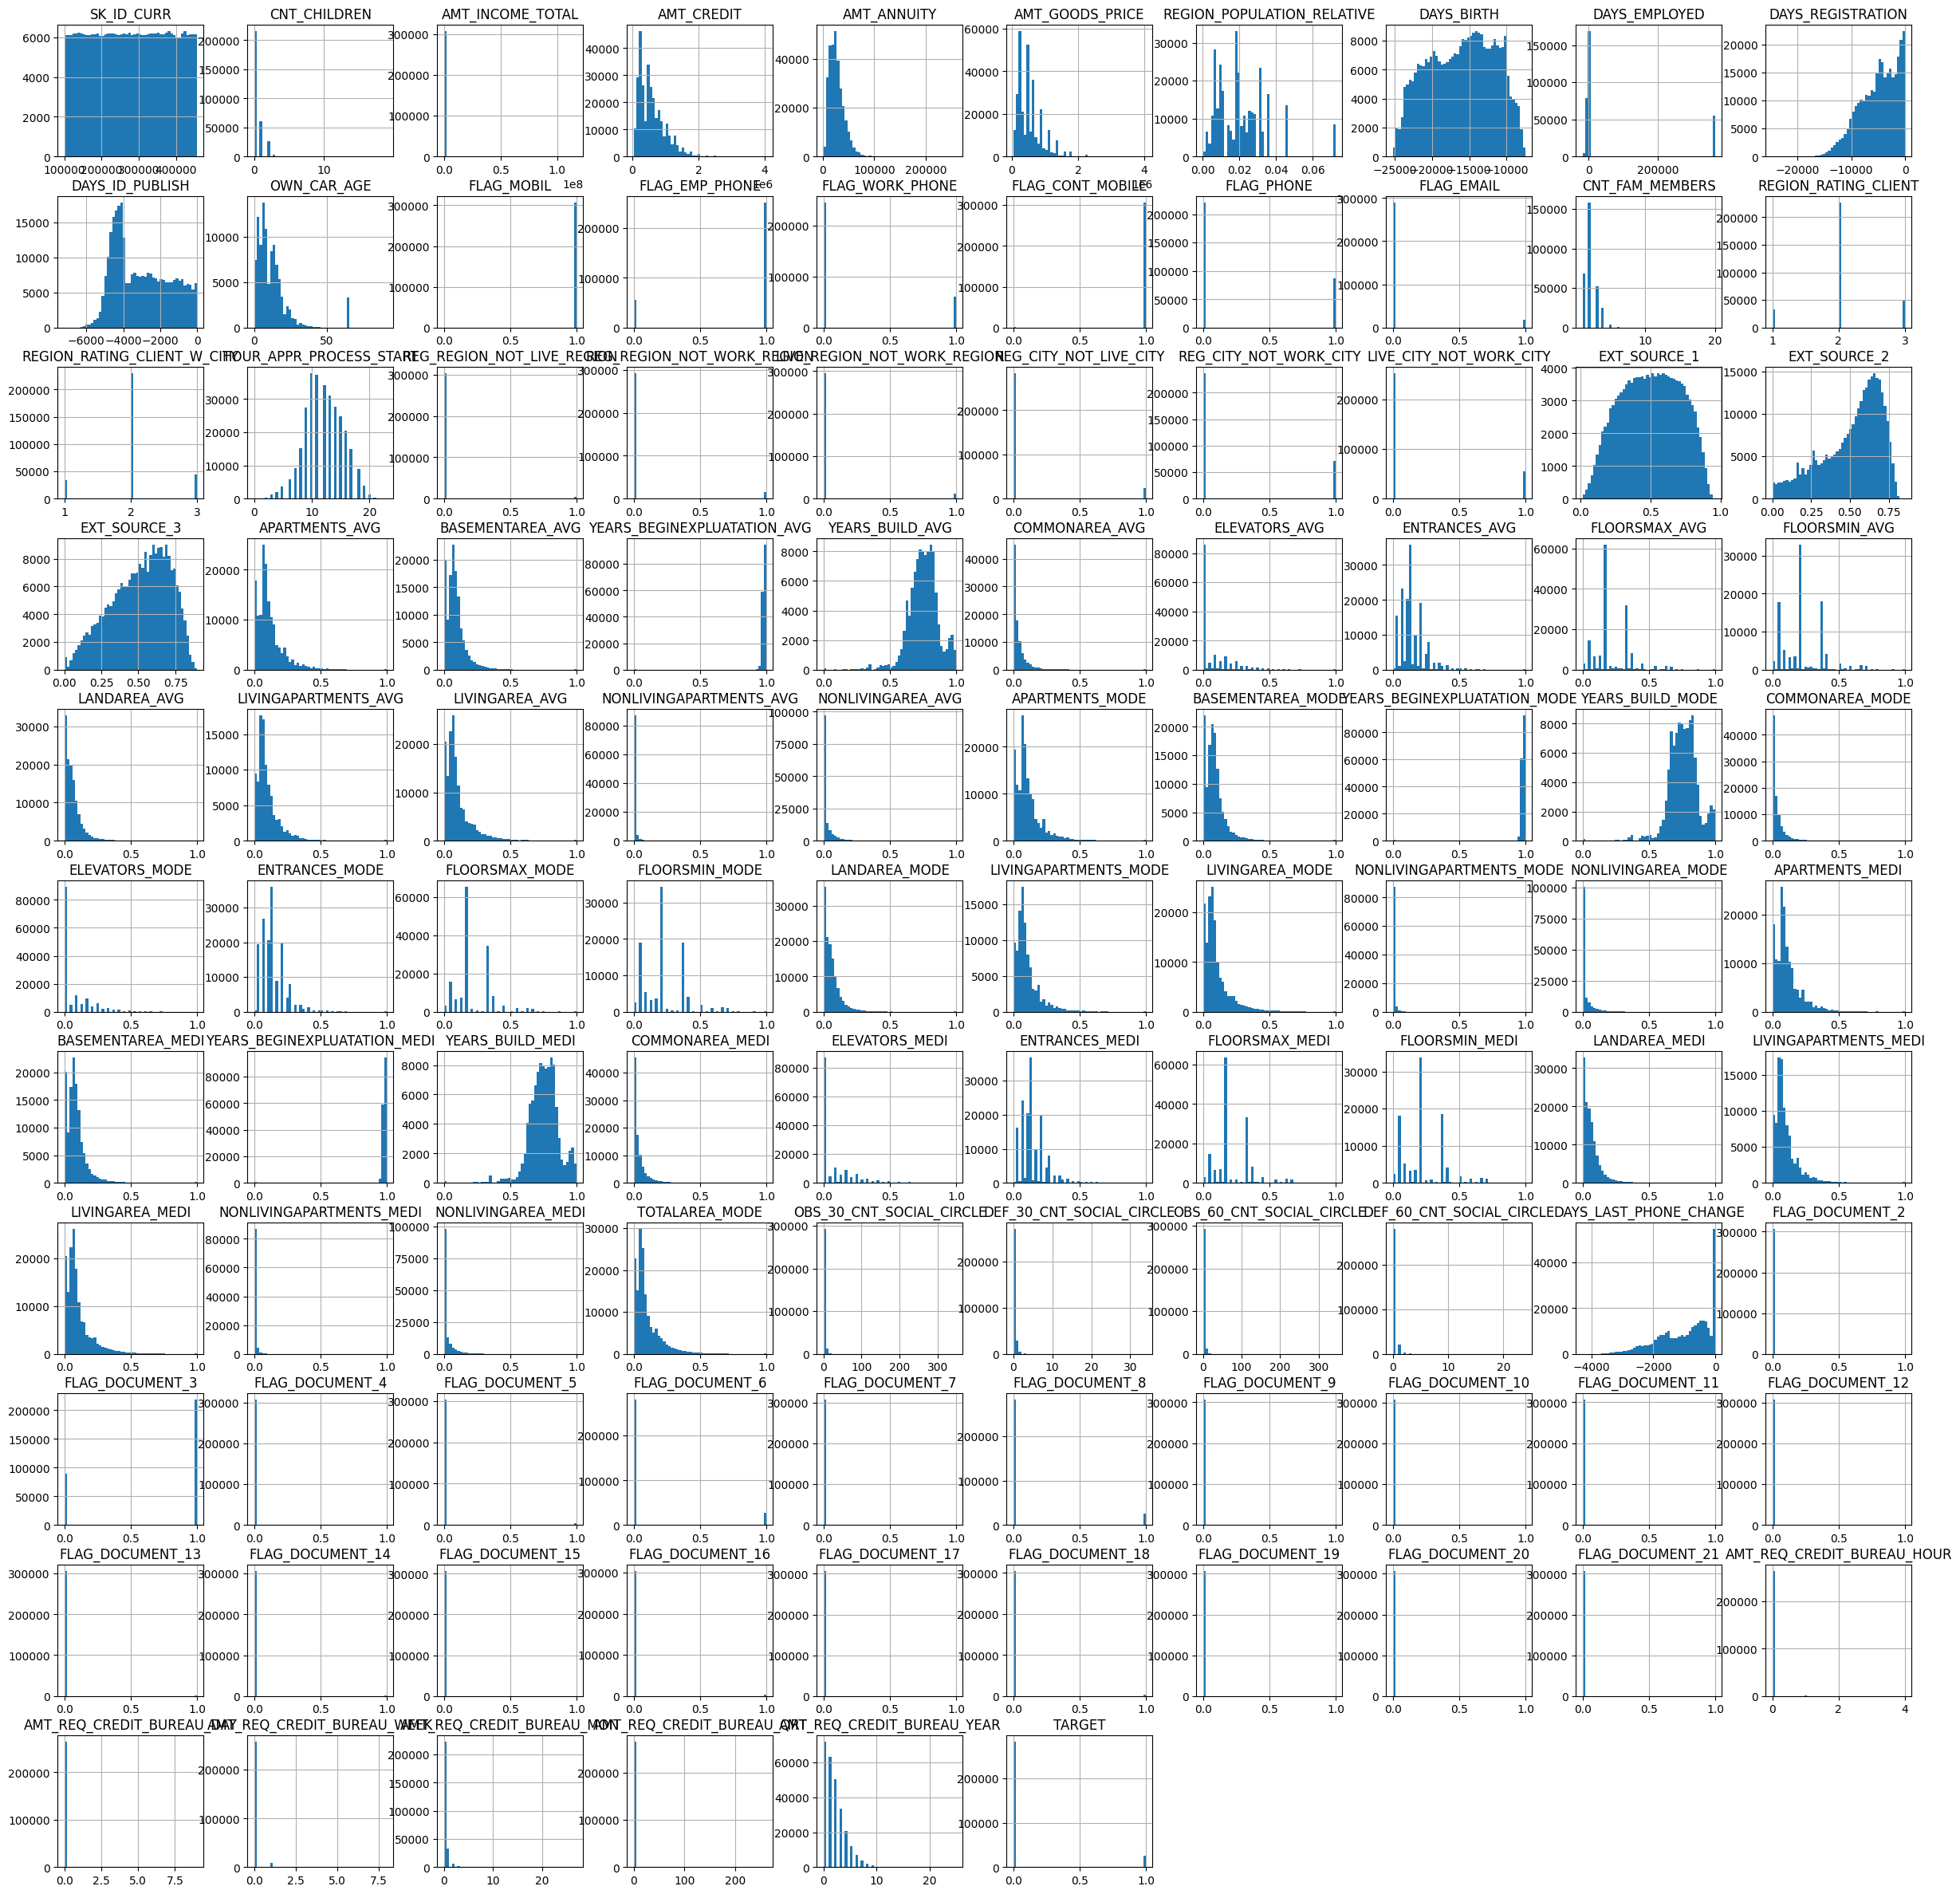

In [50]:
train.select_dtypes(include=[np.number]).hist(bins = 50, figsize = (30,30))
plt.show()

In [58]:
(train['DAYS_BIRTH']/(-365)).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [59]:
(train['DAYS_EMPLOYED']/(-365)).describe()

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [65]:
sum(train['DAYS_EMPLOYED'] == 365243)

55374

In [69]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].replace({365243:np.nan})

In [70]:
(train['DAYS_EMPLOYED']/(-365)).describe()

count    252137.000000
mean          6.531971
std           6.406466
min          -0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [76]:
(train['DAYS_REGISTRATION']/(-365)).describe()

count    307511.000000
mean         13.660604
std           9.651743
min          -0.000000
25%           5.506849
50%          12.339726
75%          20.491781
max          67.594521
Name: DAYS_REGISTRATION, dtype: float64

In [77]:
(train['DAYS_ID_PUBLISH']/(-365)).describe()

count    307511.000000
mean          8.203294
std           4.135481
min          -0.000000
25%           4.712329
50%           8.915068
75%          11.778082
max          19.717808
Name: DAYS_ID_PUBLISH, dtype: float64

<Axes: >

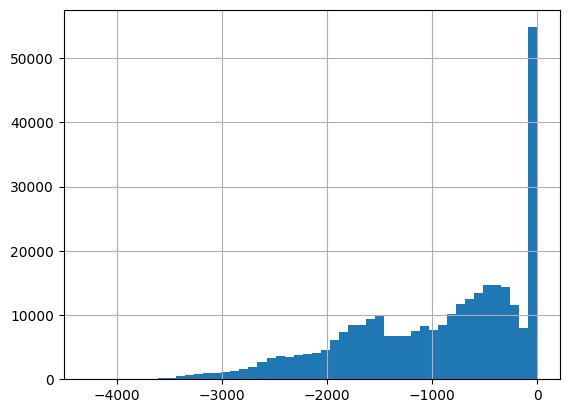

In [97]:
train['DAYS_LAST_PHONE_CHANGE'].hist(bins = 50)

<Axes: xlabel='TARGET', ylabel='DAYS_LAST_PHONE_CHANGE'>

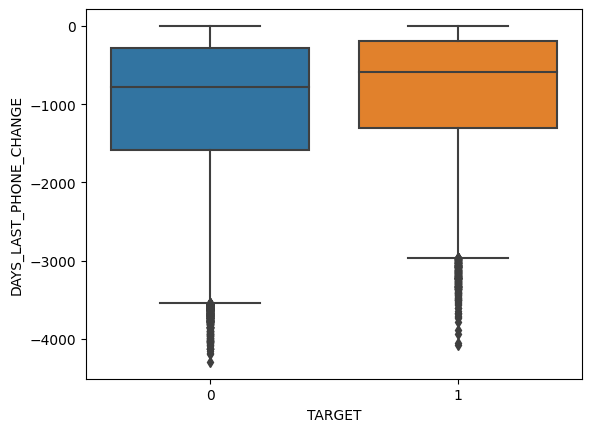

In [86]:
sns.boxplot(x = 'TARGET' , y = 'DAYS_LAST_PHONE_CHANGE' ,data = train)

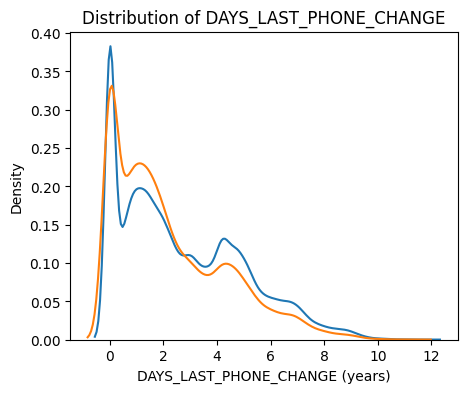

In [102]:
plt.figure(figsize = (5, 4))

# KDE plot of loans that were repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_LAST_PHONE_CHANGE'] / (-365), label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_LAST_PHONE_CHANGE'] / (-365), label = 'target == 1')

# Labeling of plot
plt.xlabel('DAYS_LAST_PHONE_CHANGE (years)'); plt.ylabel('Density'); plt.title('Distribution of DAYS_LAST_PHONE_CHANGE');

In [92]:
train[train['DAYS_LAST_PHONE_CHANGE'] < -2000]['TARGET'].mean()*100

5.519176800748363

In [93]:
train[train['DAYS_LAST_PHONE_CHANGE'] < -3000]['TARGET'].mean()*100

4.435568635694766

In [94]:
train[train['DAYS_LAST_PHONE_CHANGE'] < -1000]['TARGET'].mean()*100

6.377356137260098

In [80]:
anom = train[train['DAYS_LAST_PHONE_CHANGE'] == 0]
non_anom = train[train['DAYS_LAST_PHONE_CHANGE'] != 0]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 7.85% of loans
The anomalies default on 9.67% of loans
There are 37672 anomalous days of employment


In [122]:
correlations = train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [124]:
train['DAYS_BIRTH'] = abs(train['DAYS_BIRTH'])
train['DAYS_BIRTH'].corr(train['TARGET'])

-0.07823930830982709

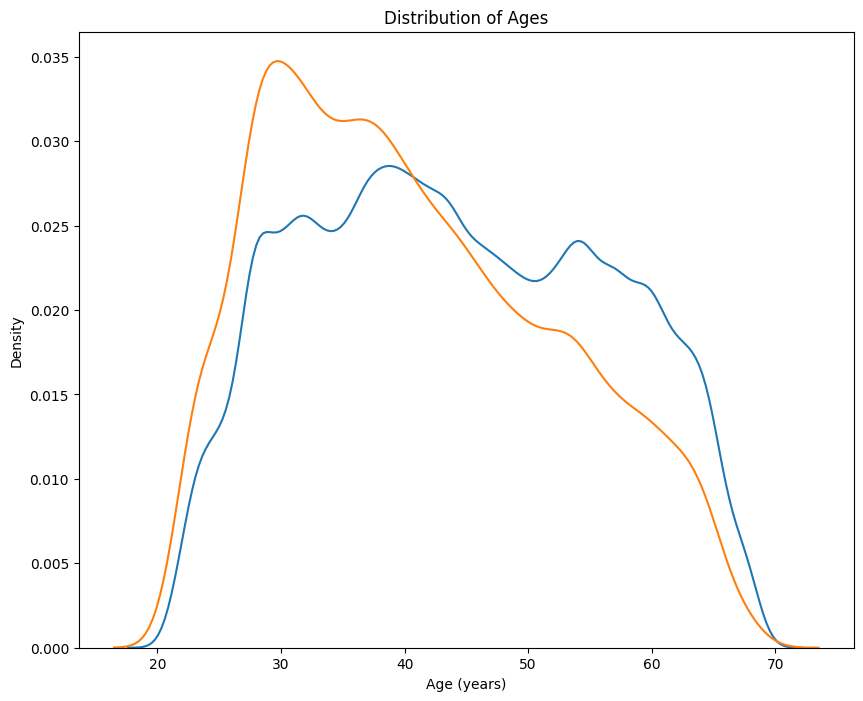

In [125]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [126]:
age_data = train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

In [127]:
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

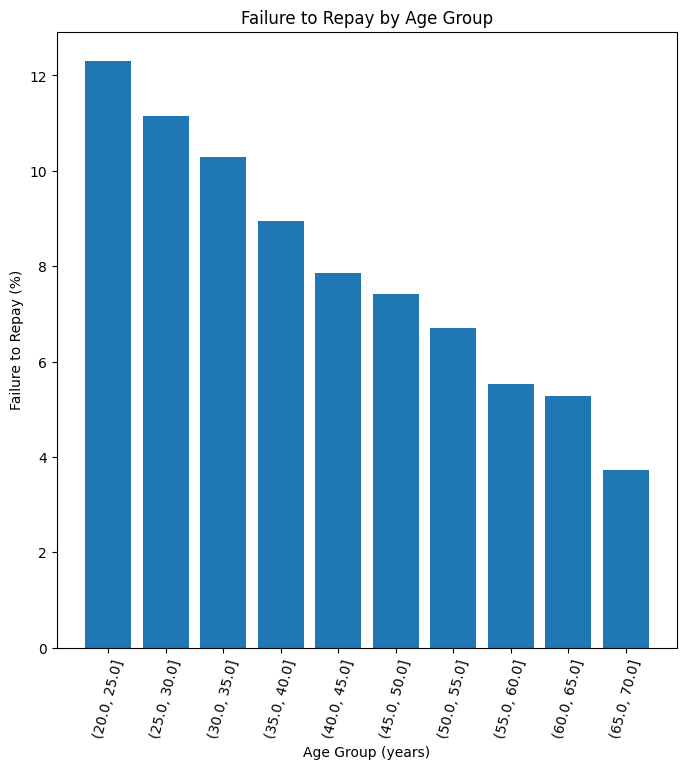

In [128]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

In [129]:
ext_data = train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

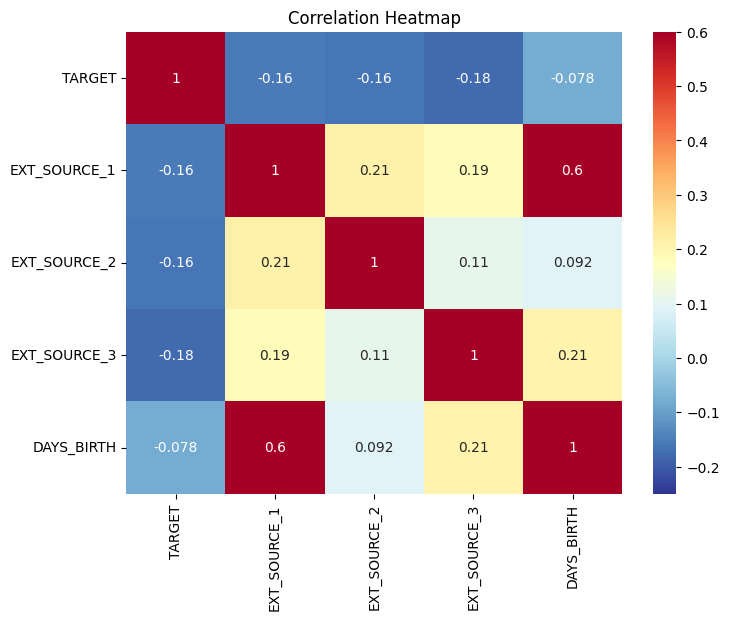

In [130]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

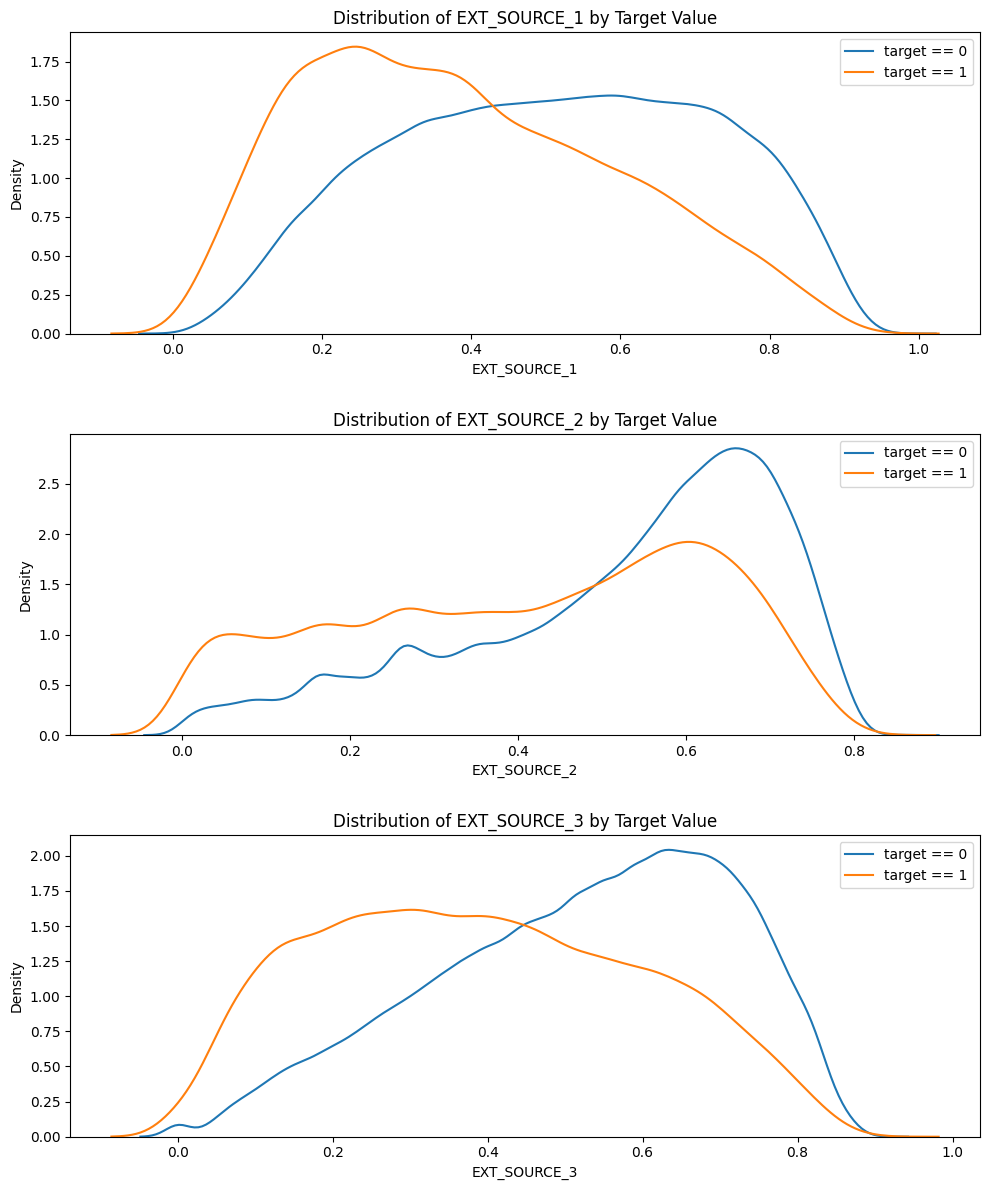

In [134]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(train.loc[train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(train.loc[train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)
plt.show()

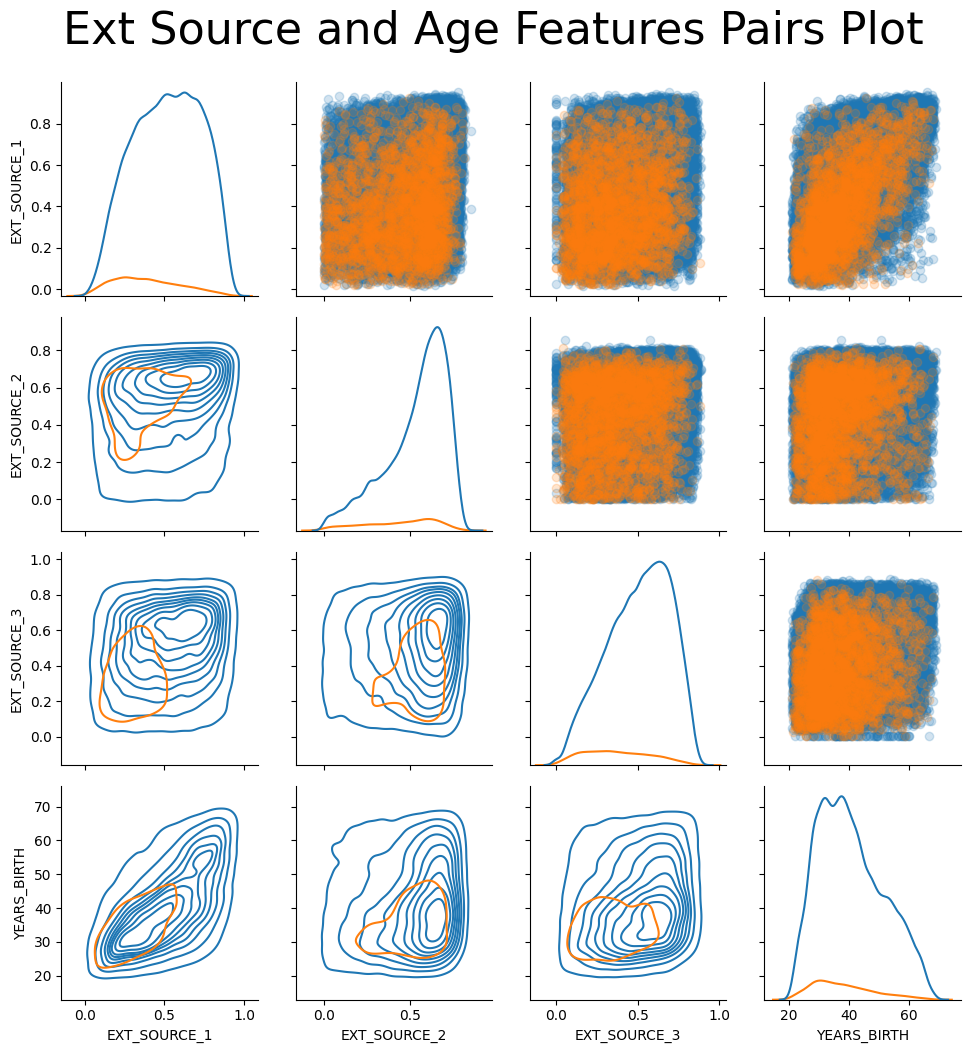

In [136]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);


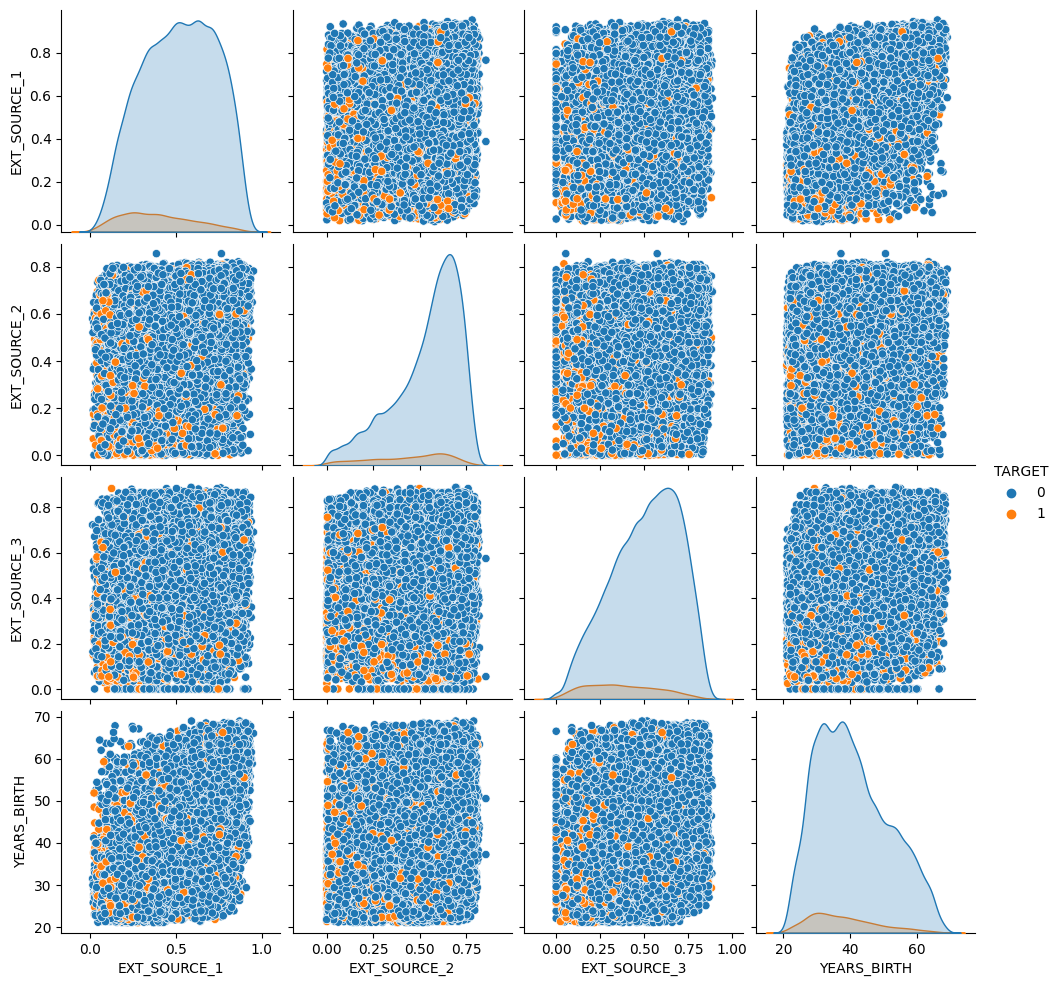

In [138]:
sns.pairplot(plot_data, hue = 'TARGET',size = 2.5)
plt.show()

## Feature Engineering

In [139]:
# Make a new dataframe for polynomial features
poly_features = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

ImportError: cannot import name 'Imputer' from 'sklearn.preprocessing' (/Users/eliottjiang/miniforge3/lib/python3.10/site-packages/sklearn/preprocessing/__init__.py)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pandas as pd

def perform_grid_search(classifier, param_grid, X_train, y_train):
    """
    Perform grid search with cross-validation.

    :param classifier: The classifier to be tuned
    :param param_grid: The grid of parameters to search over
    :param X_train: Training data features
    :param y_train: Training data labels
    :return: Best parameters and scores
    """
    # Define scoring metrics
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score)
    }

    # Create k-fold cross-validation strategy
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)

    # Create GridSearchCV instance
    grid_search = GridSearchCV(classifier, param_grid, scoring=scoring, cv=kfold, refit='recall')

    # Create pipeline
    pipeline = make_pipeline(StandardScaler(), grid_search)

    # Train the model
    pipeline.fit(X_train, y_train)

    # Get the best parameters
    best_params = grid_search.best_params_
    
    # Get the best es ti
    best_estimator = grid_search.best_estimator_

    # Get cross-validation results
    cv_results = grid_search.cv_results_

    # Extract performance metrics for the best parameter combination
    best_scores = {
        'best_f1_score': np.mean(cv_results['mean_test_f1']),
        'best_accuracy': np.mean(cv_results['mean_test_accuracy']),
        'best_precision': np.mean(cv_results['mean_test_precision']),
        'best_recall': np.mean(cv_results['mean_test_recall'])
    }

    return best_params, best_estimator, best_scores



## Baseline Model

## Improvement model and technique

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

random_forest.fit(train, train_labels)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]


In [ ]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [ ]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [21]:
(train['DAYS_EMPLOYED']/(-365)).describe()

count    252137.000000
mean          6.531971
std           6.406466
min          -0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [18]:
anom = train[train['DAYS_EMPLOYED'] == 365243]
non_anom = train[train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


In [19]:
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

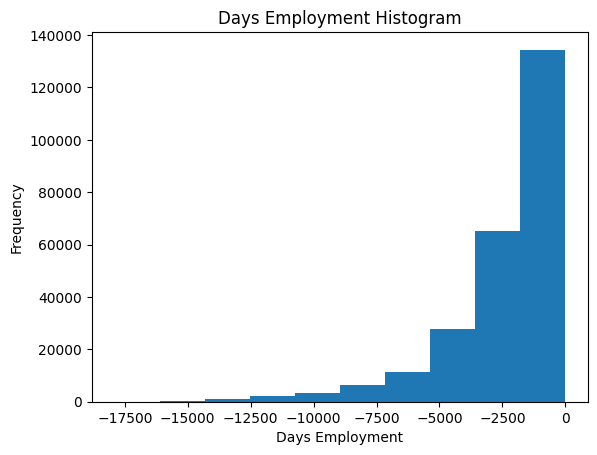

In [20]:
train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [40]:
train['NAME_INCOME_TYPE'].value_counts()

NAME_INCOME_TYPE
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: count, dtype: int64

In [35]:
sum(train['DAYS_LAST_PHONE_CHANGE'] == 0)

37672

In [36]:
anom = train[train['DAYS_LAST_PHONE_CHANGE'] == 0]
non_anom = train[train['DAYS_LAST_PHONE_CHANGE'] != 0]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 7.85% of loans
The anomalies default on 9.67% of loans
There are 37672 anomalous days of employment


In [45]:
age_data = train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / (-365)

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

/var/folders/r_/gqv3cs7s79l_2lllsh1hrcf40000gn/T/ipykernel_94666/3331508741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / (-365)
/var/folders/r_/gqv3cs7s79l_2lllsh1hrcf40000gn/T/ipykernel_94666/3331508741.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))


TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1       -9461    25.920548  (25.0, 30.0]
1       0      -16765    45.931507  (45.0, 50.0]
2       0      -19046    52.180822  (50.0, 55.0]
3       0      -19005    52.068493  (50.0, 55.0]
4       0      -19932    54.608219  (50.0, 55.0]
5       0      -16941    46.413699  (45.0, 50.0]
6       0      -13778    37.747945  (35.0, 40.0]
7       0      -18850    51.643836  (50.0, 55.0]
8       0      -20099    55.065753  (55.0, 60.0]
9       0      -14469    39.641096  (35.0, 40.0]

In [46]:
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036  -8532.795625    23.377522
(25.0, 30.0]  0.111436 -10155.219250    27.822518
(30.0, 35.0]  0.102814 -11854.848377    32.479037
(35.0, 40.0]  0.089414 -13707.908253    37.555913
(40.0, 45.0]  0.078491 -15497.661233    42.459346
(45.0, 50.0]  0.074171 -17323.900441    47.462741
(50.0, 55.0]  0.066968 -19196.494791    52.593136
(55.0, 60.0]  0.055314 -20984.262742    57.491131
(60.0, 65.0]  0.052737 -22780.547460    62.412459
(65.0, 70.0]  0.037270 -24292.614340    66.555108

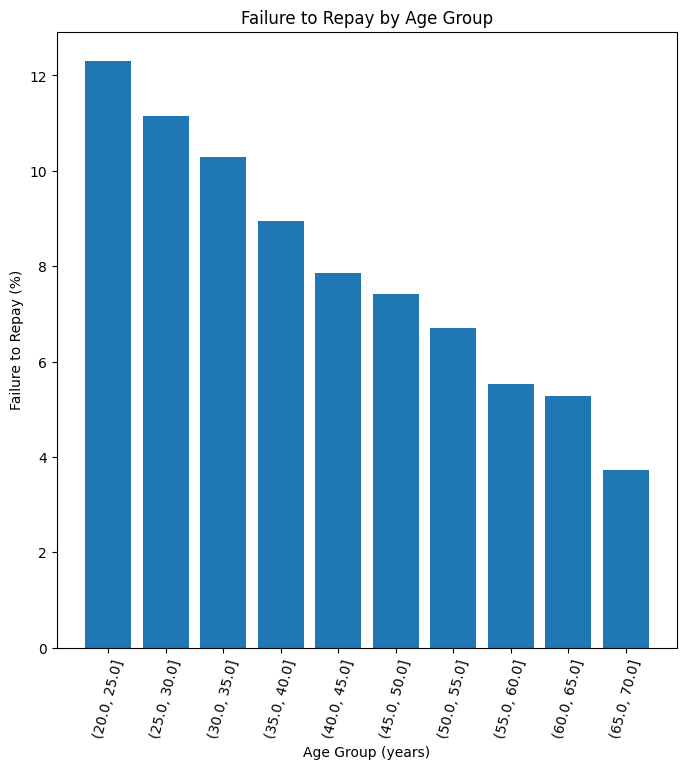

In [47]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

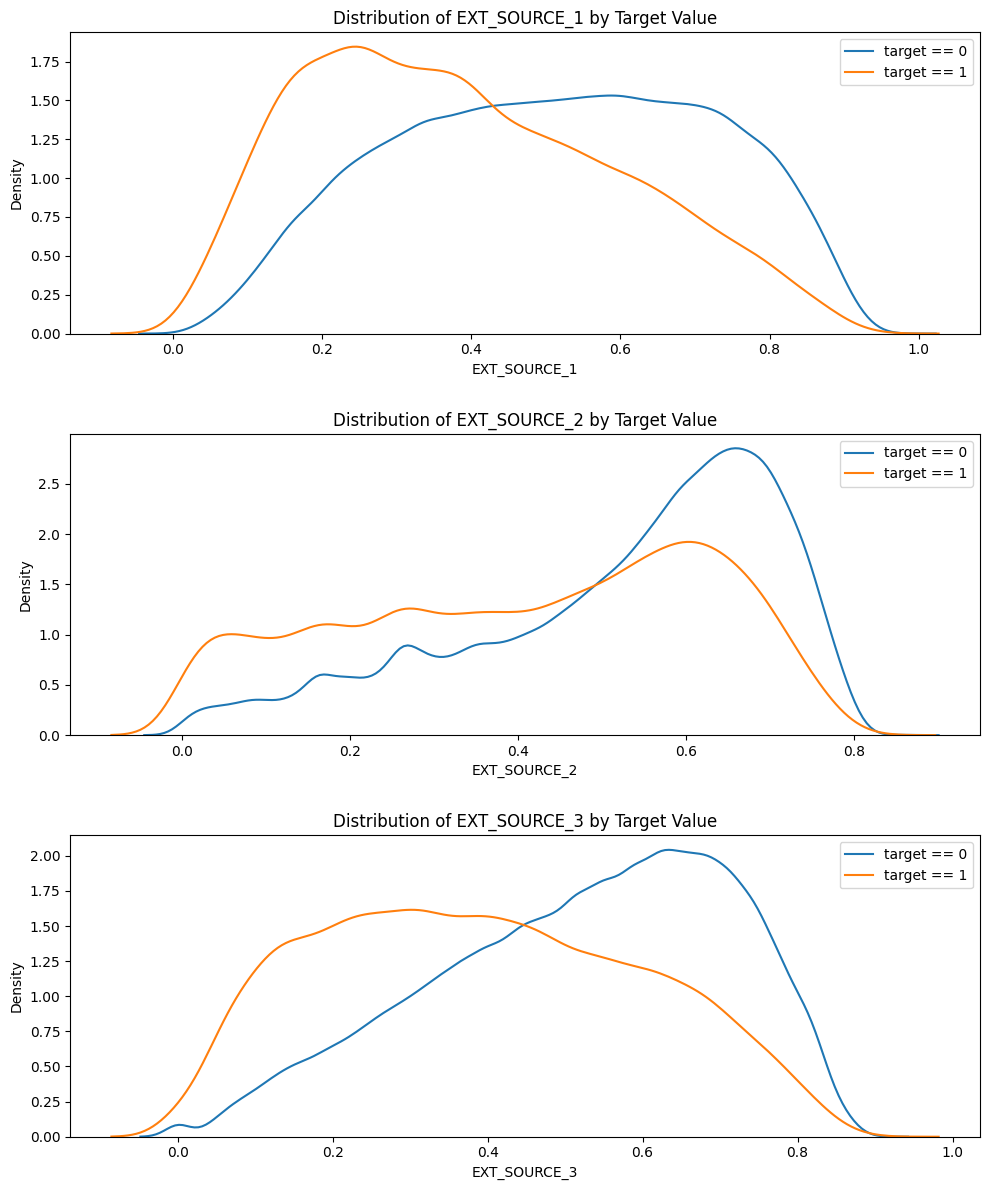

In [51]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(train.loc[train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(train.loc[train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density')
    plt.legend()
    

plt.tight_layout(h_pad = 2.5)
plt.show()

In [42]:
pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
307506    NaN
307507    NaN
307508    NaN
307509    NaN
307510    NaN
Name: YEARS_BIRTH, Length: 307511, dtype: category
Categories (10, interval[float64, right]): [(20.0, 25.0] < (25.0, 30.0] < (30.0, 35.0] < (35.0, 40.0] ... (50.0, 55.0] < (55.0, 60.0] < (60.0, 65.0] < (65.0, 70.0]]

In [4]:
numeric_train = train.select_dtypes(include=[np.number])
object_train = train.select_dtypes(include=[object])

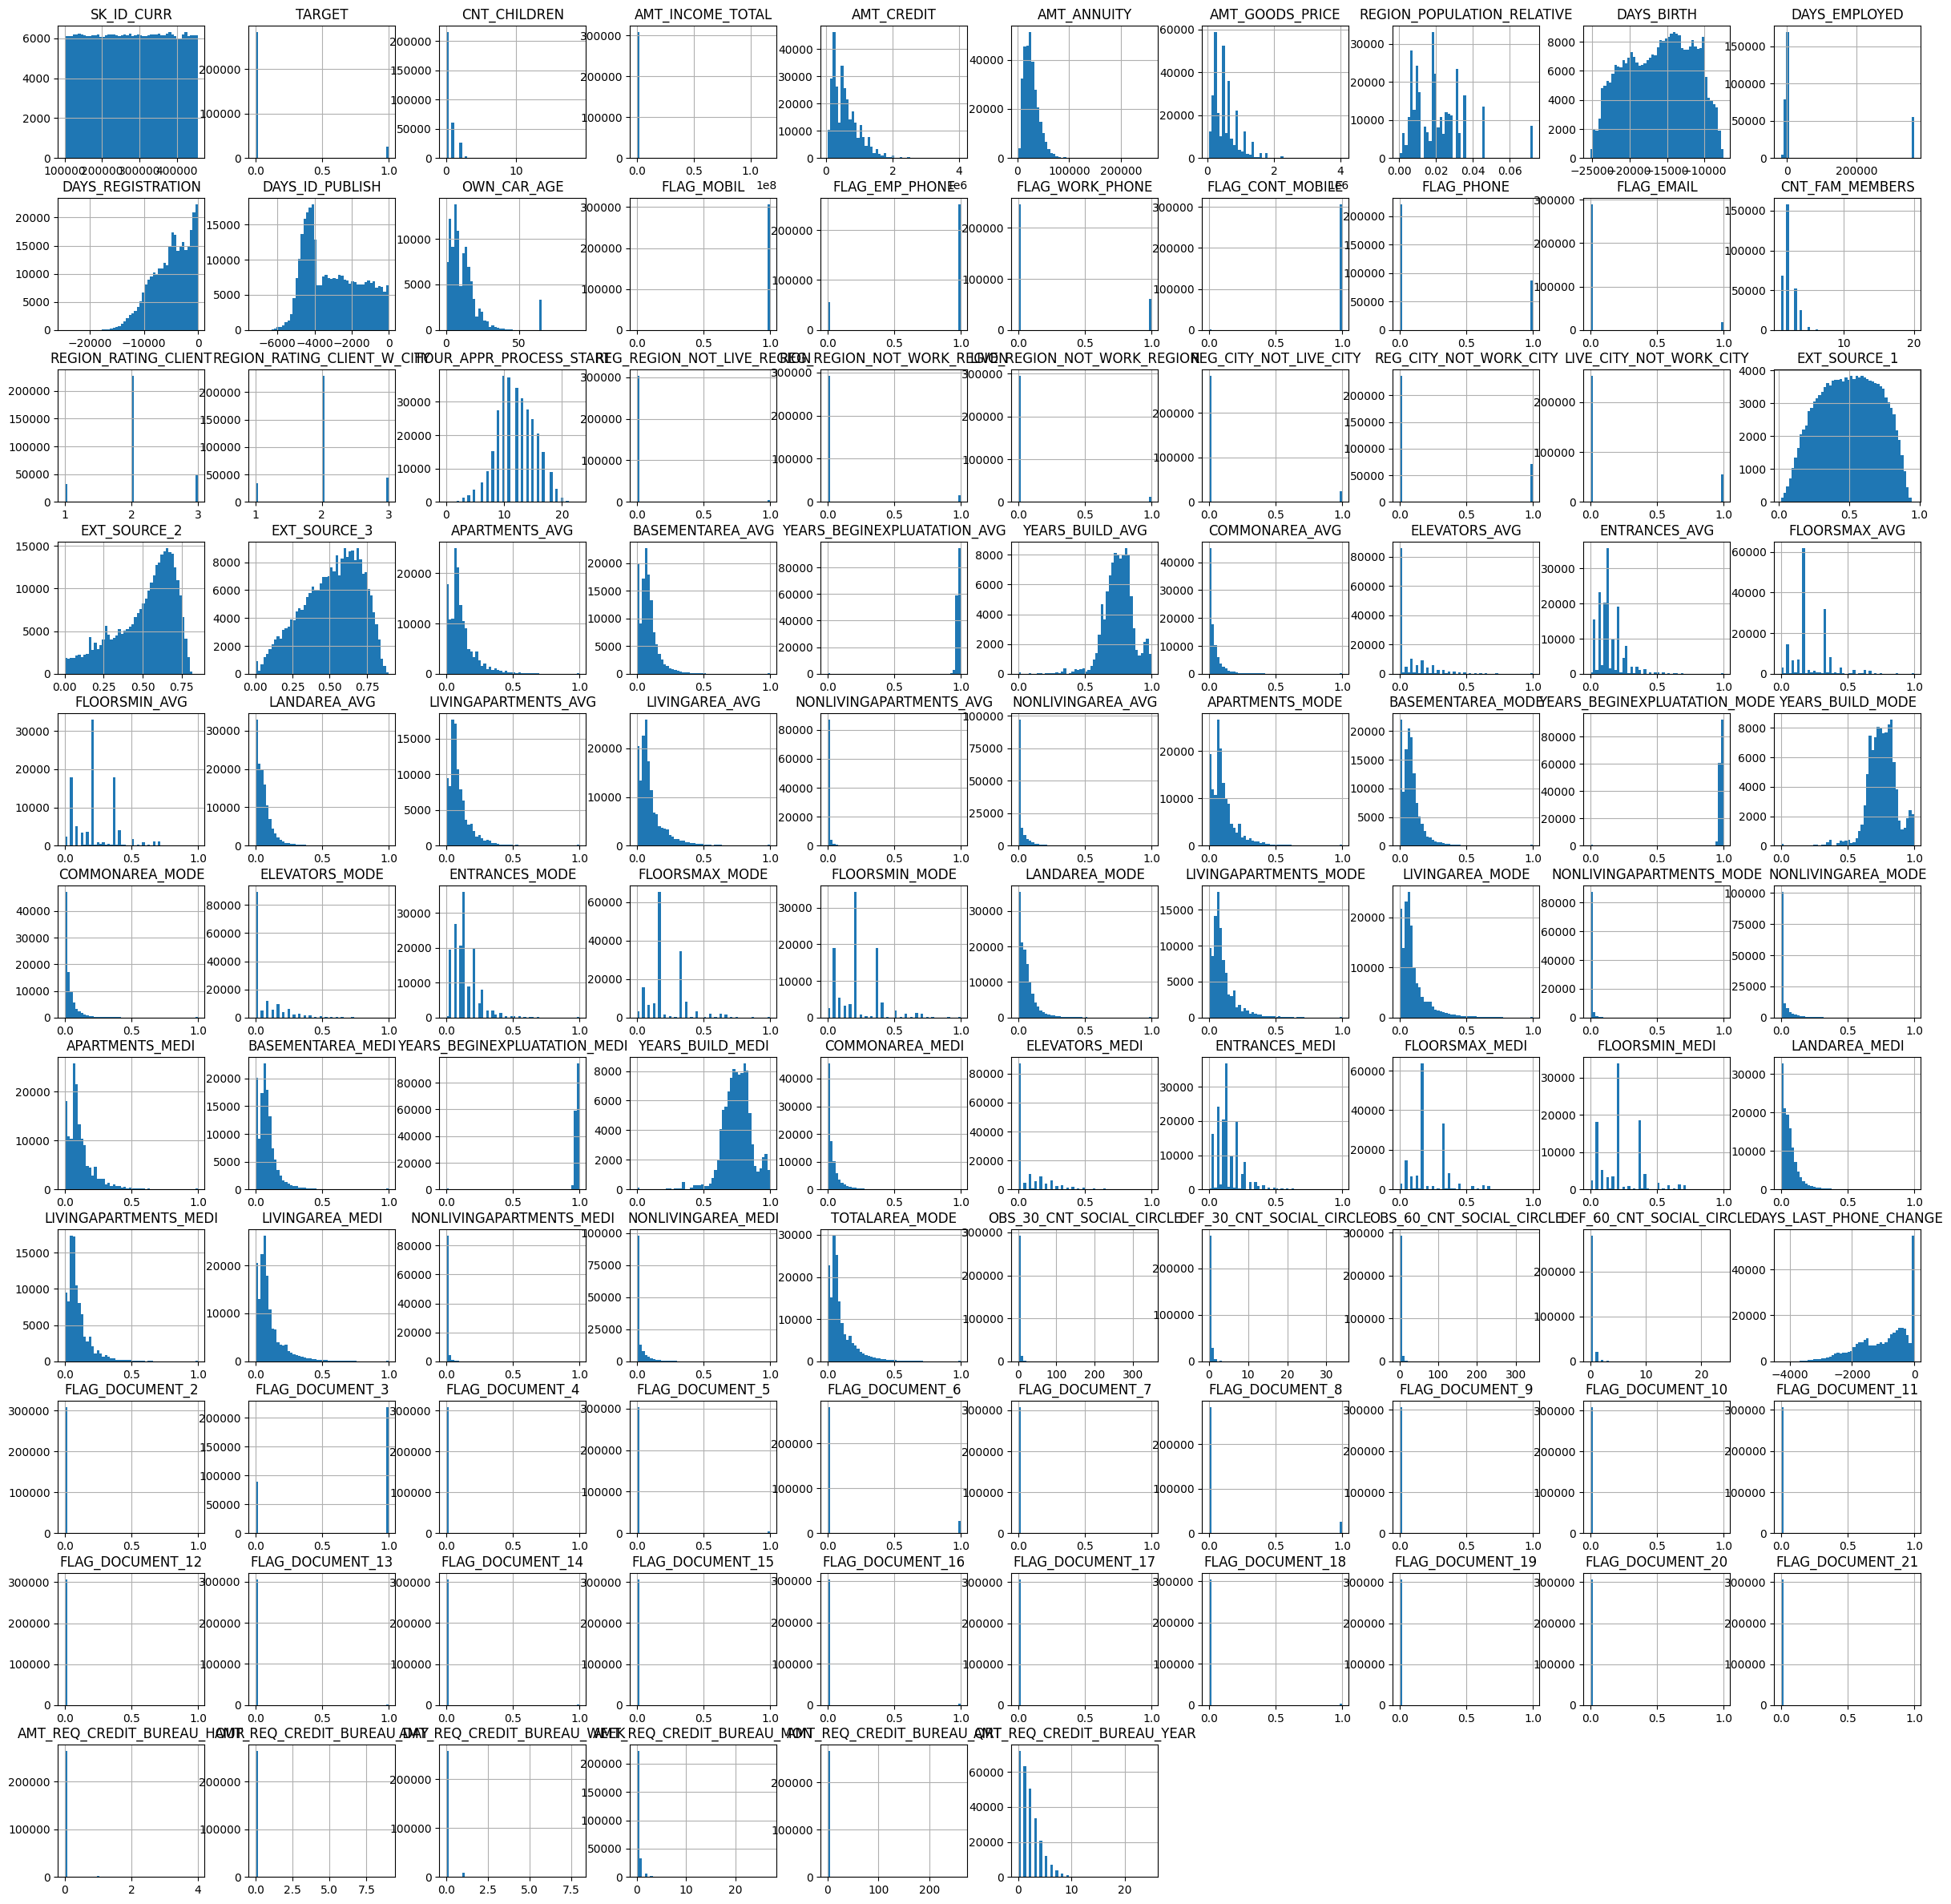

In [ ]:
numeric_train.hist(bins = 50, figsize = (30,30))
plt.show()

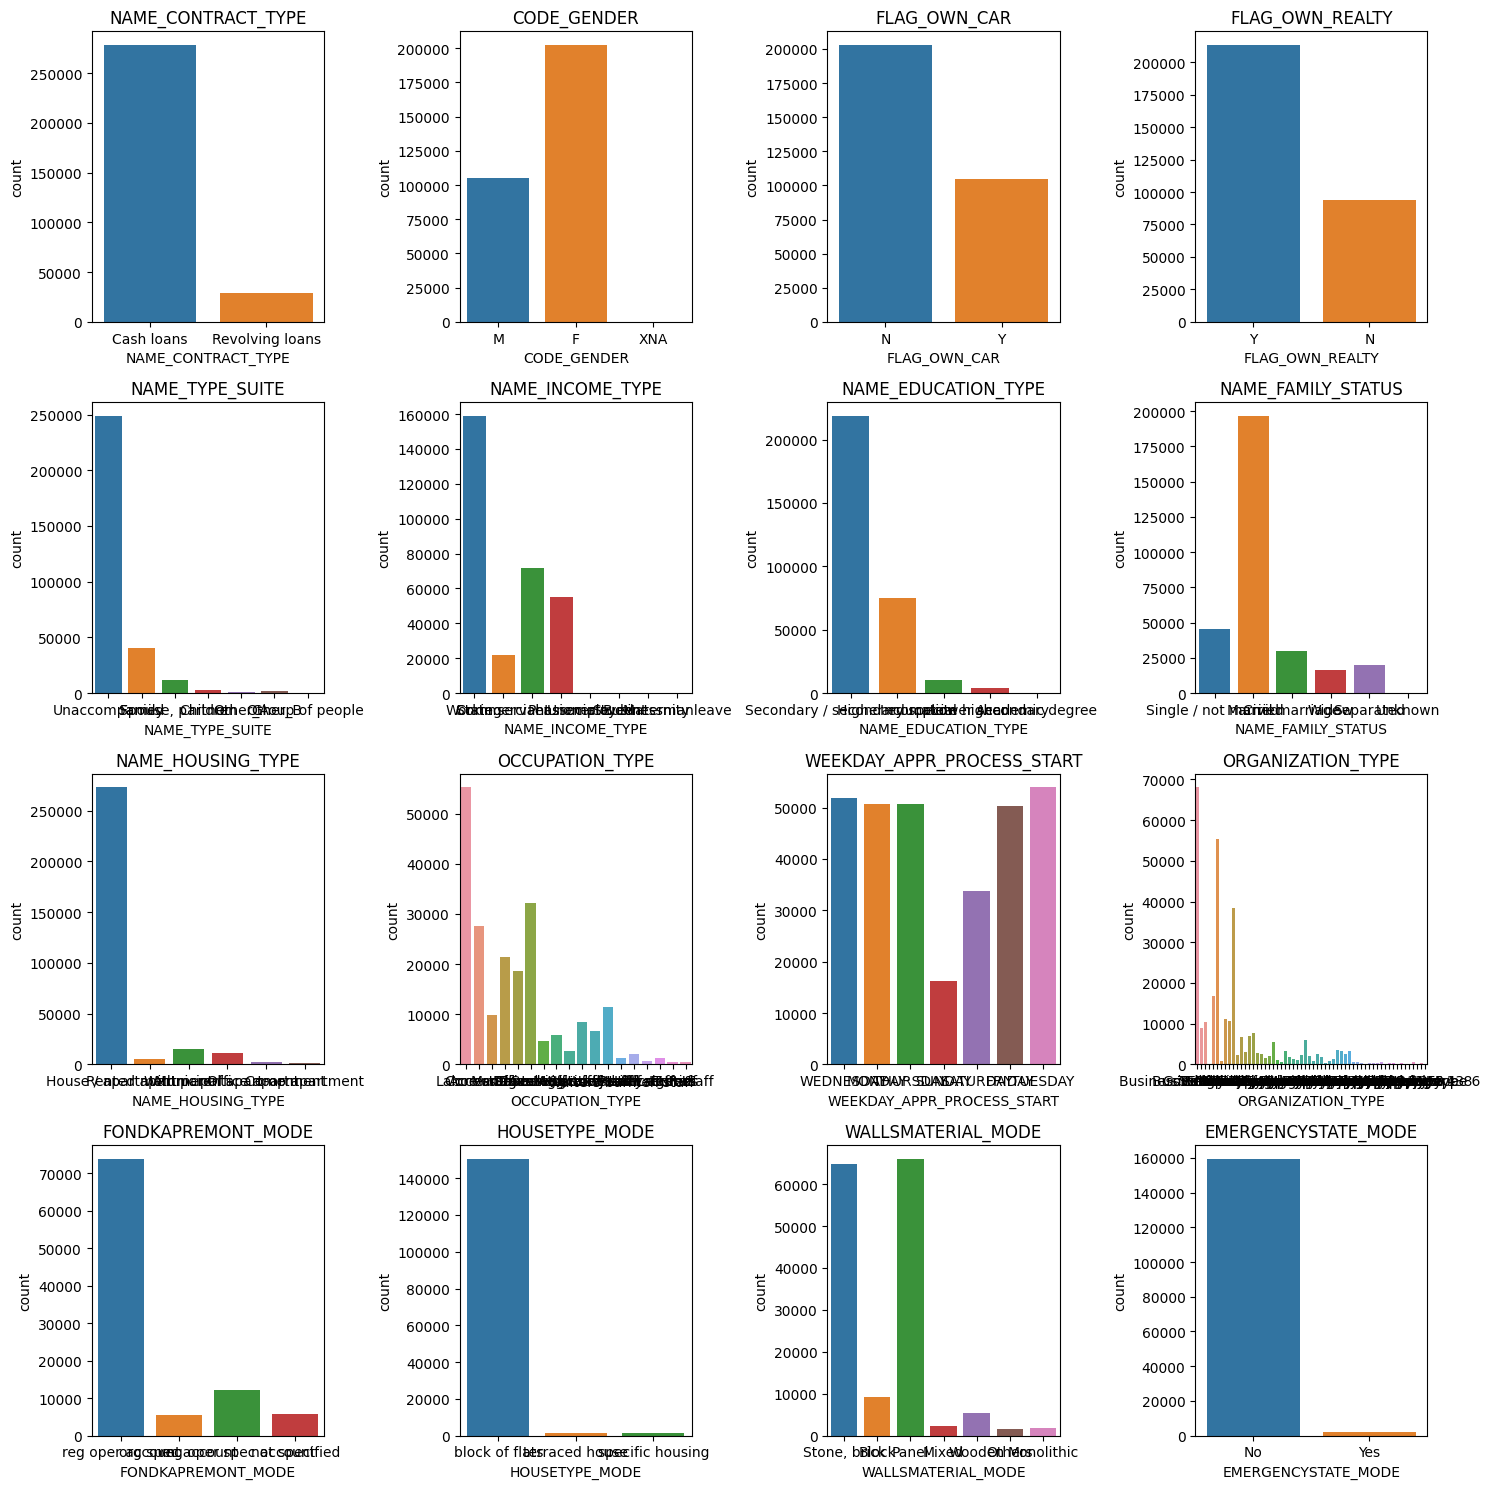

In [6]:
f, axes = plt.subplots(nrows = 4, ncols=4, figsize=(15,15))
axess = axes.flatten()

i = 0
for column in object_train.columns:
    sns.countplot(x = column,data = object_train, ax=axess[i])
    axess[i].set_title(column)
    i+=1

    
plt.tight_layout()
plt.show()

In [7]:
def find_nan_values(df):
    if df.isnull().values.any():
        null_columns=df.columns[df.isnull().any()].tolist()
        for column in null_columns:
            total_values=df.shape[0]
            null_values=df[column].isnull().sum()
            print("No. of Nan Values in '{}' column --> {}".format(column,null_values))
            print("{:.2f} % of Total values".format((100 * null_values) / total_values))
            print("\n")
    else:
        print("No Column has Nan Values")

In [8]:
find_nan_values(train)

No. of Nan Values in 'AMT_ANNUITY' column --> 12
0.00 % of Total values


No. of Nan Values in 'AMT_GOODS_PRICE' column --> 278
0.09 % of Total values


No. of Nan Values in 'NAME_TYPE_SUITE' column --> 1292
0.42 % of Total values


No. of Nan Values in 'OWN_CAR_AGE' column --> 202929
65.99 % of Total values


No. of Nan Values in 'OCCUPATION_TYPE' column --> 96391
31.35 % of Total values


No. of Nan Values in 'CNT_FAM_MEMBERS' column --> 2
0.00 % of Total values


No. of Nan Values in 'EXT_SOURCE_1' column --> 173378
56.38 % of Total values


No. of Nan Values in 'EXT_SOURCE_2' column --> 660
0.21 % of Total values


No. of Nan Values in 'EXT_SOURCE_3' column --> 60965
19.83 % of Total values


No. of Nan Values in 'APARTMENTS_AVG' column --> 156061
50.75 % of Total values


No. of Nan Values in 'BASEMENTAREA_AVG' column --> 179943
58.52 % of Total values


No. of Nan Values in 'YEARS_BEGINEXPLUATATION_AVG' column --> 150007
48.78 % of Total values


No. of Nan Values in 'YEARS_BUILD

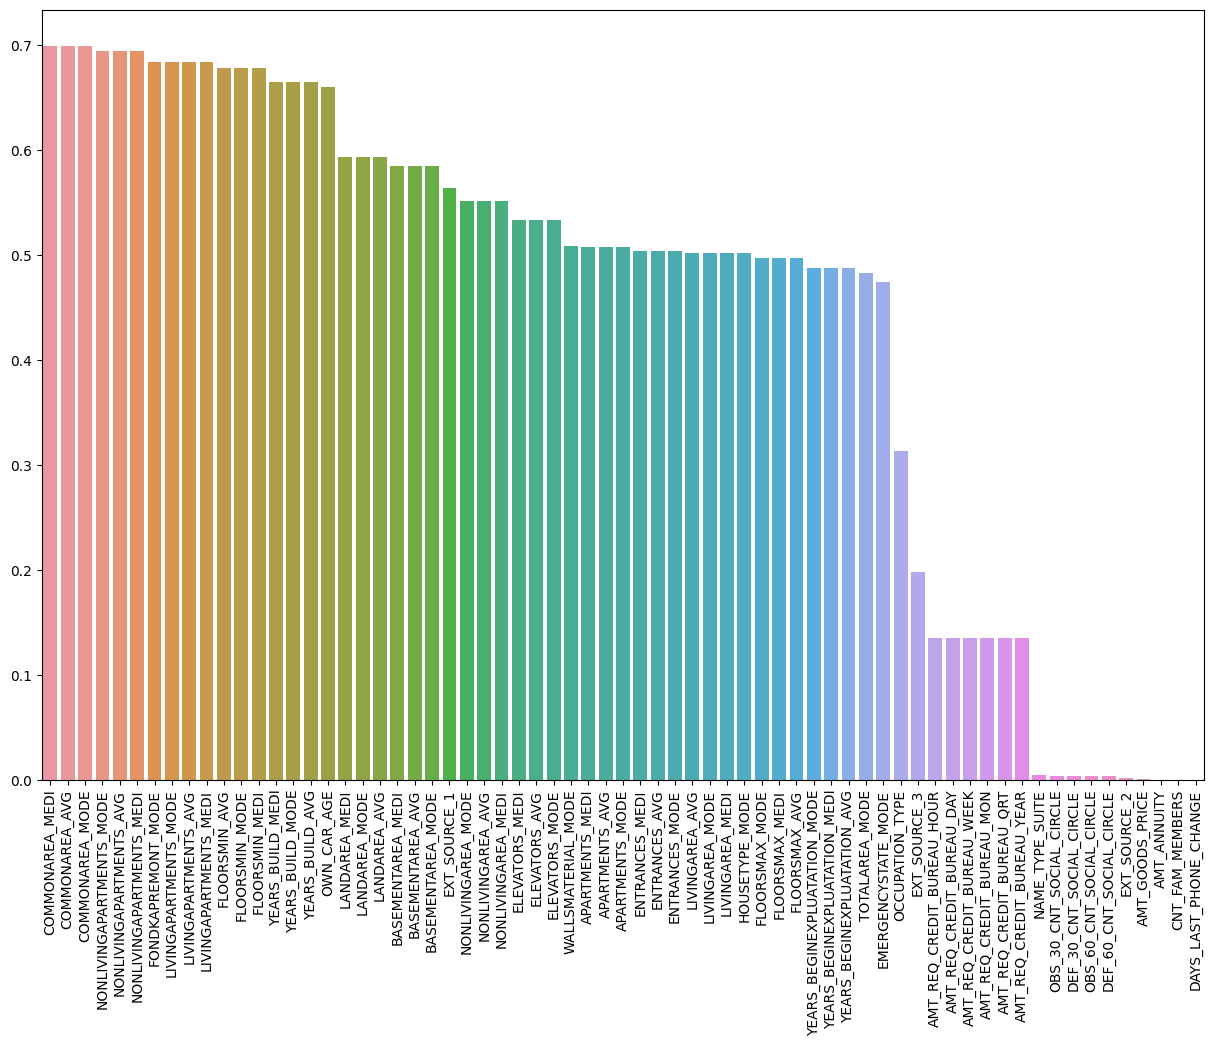

In [9]:
nacount = train.isna().sum().sort_values(ascending = False)/len(train)
nacount = nacount[nacount>0]
plt.figure(figsize = (15,10))
sns.barplot(x = nacount.index, y = nacount.values)
plt.xticks(rotation=90);

In [10]:
corr_with_target = numeric_train.corr()['TARGET'].sort_values()

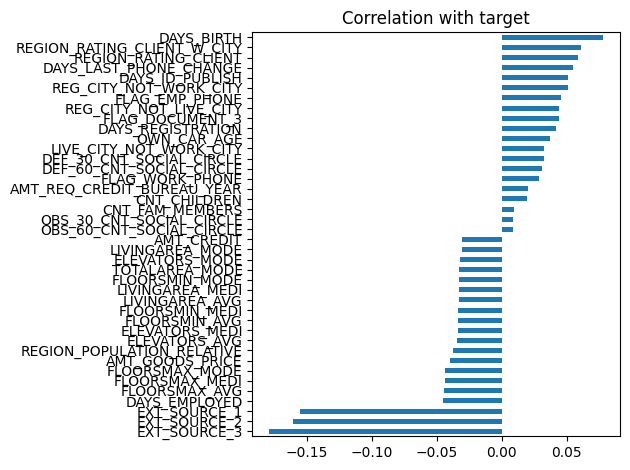

In [11]:
pd.concat([corr_with_target.head(20),
                     corr_with_target.iloc[-21:-1]]).plot(kind = "barh")
plt.title("Correlation with target")
plt.tight_layout()
plt.show()

In [12]:
Building_features = [x for x in numeric_train.columns if x.endswith('AVG')] + [x for x in numeric_train.columns if x.endswith('MEDI')] + [x for x in numeric_train.columns if x.endswith('MODE')]

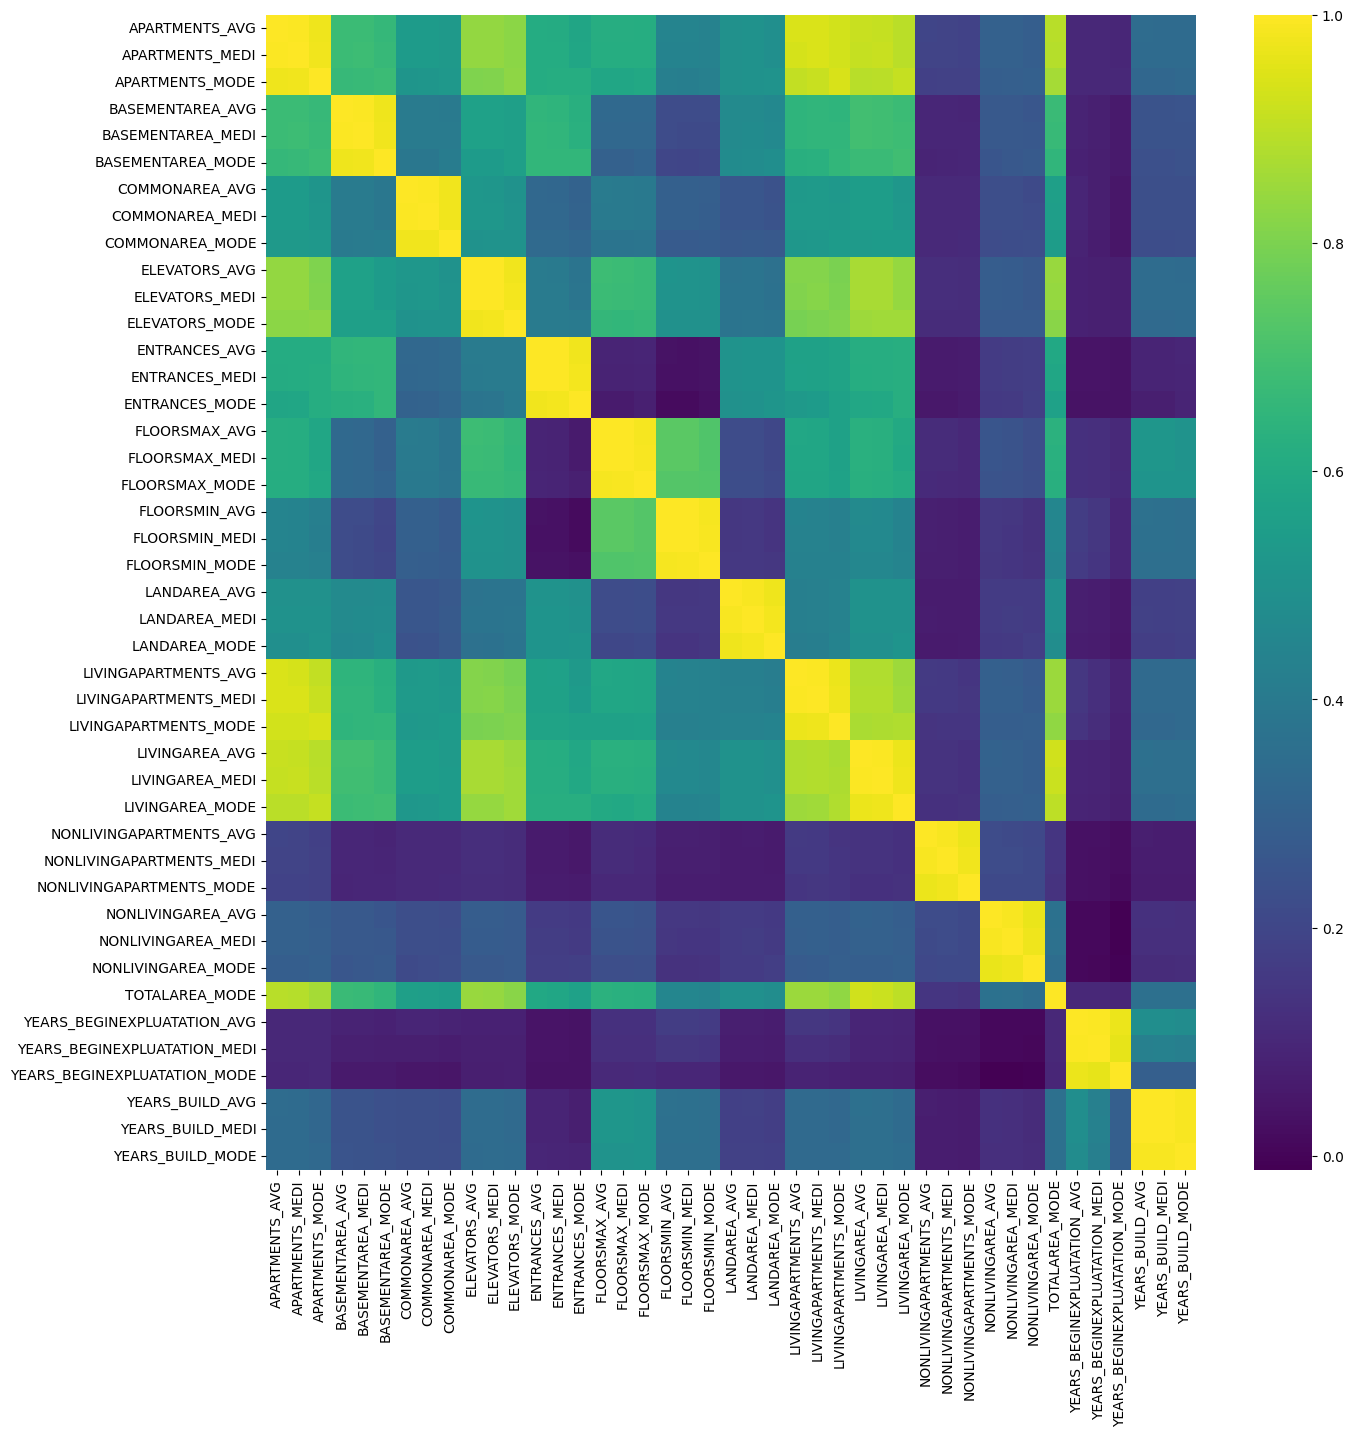

In [13]:
plt.figure(figsize = (15,15))

sns.heatmap(numeric_train[sorted(Building_features)].corr(),  annot=False ,cmap='viridis')

plt.show()

In [14]:
Social_features = [x for x in numeric_train.columns if x.endswith('SOCIAL_CIRCLE')] 

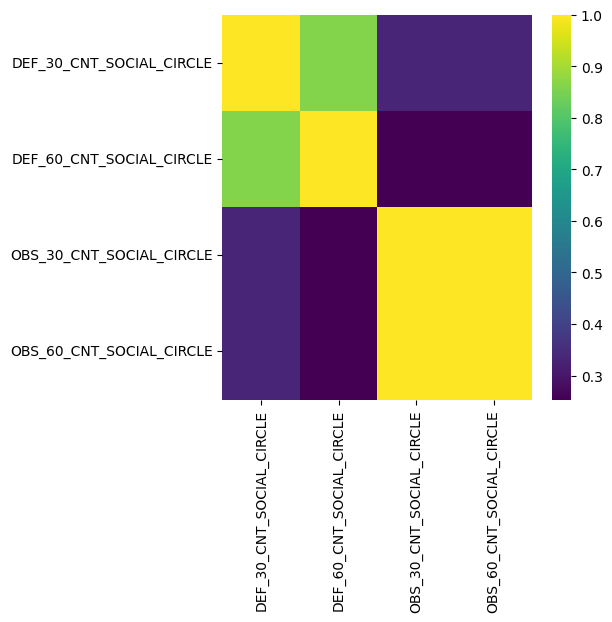

In [15]:
plt.figure(figsize = (5,5))

sns.heatmap(numeric_train[sorted(Social_features)].corr(),  annot=False ,cmap='viridis')

plt.show()

In [17]:
Document_features = [x for x in numeric_train.columns if 'FLAG_DOCUMENT' in x] 

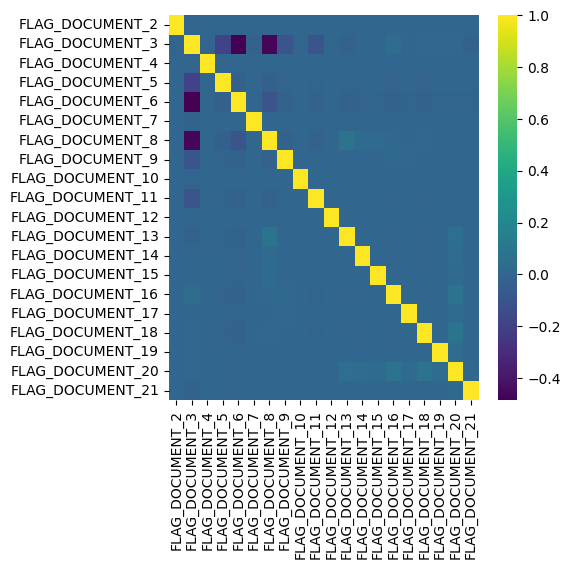

In [20]:
plt.figure(figsize = (5,5))

sns.heatmap(numeric_train[Document_features].corr(),  annot=False ,cmap='viridis')

plt.show()

In [22]:
Amt_features = [x for x in numeric_train.columns if 'AMT' in x] 

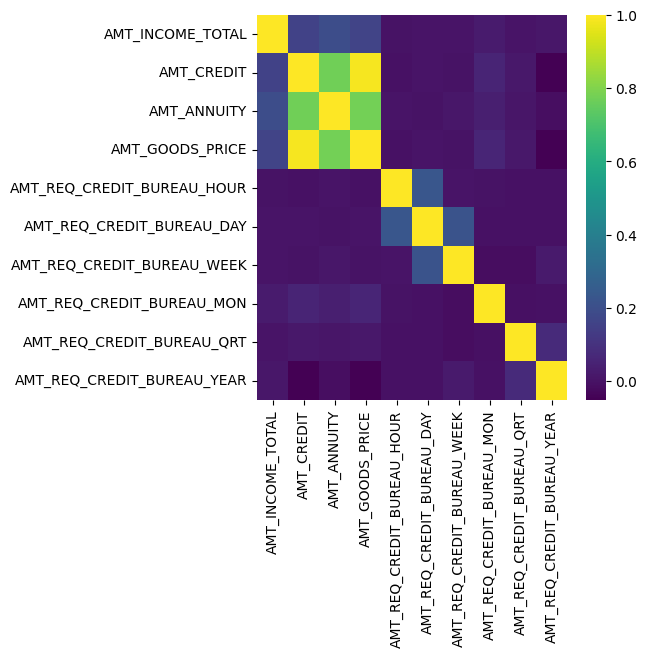

In [24]:
plt.figure(figsize = (5,5))

sns.heatmap(numeric_train[Amt_features].corr(),  annot=False ,cmap='viridis')

plt.show()

<Axes: >

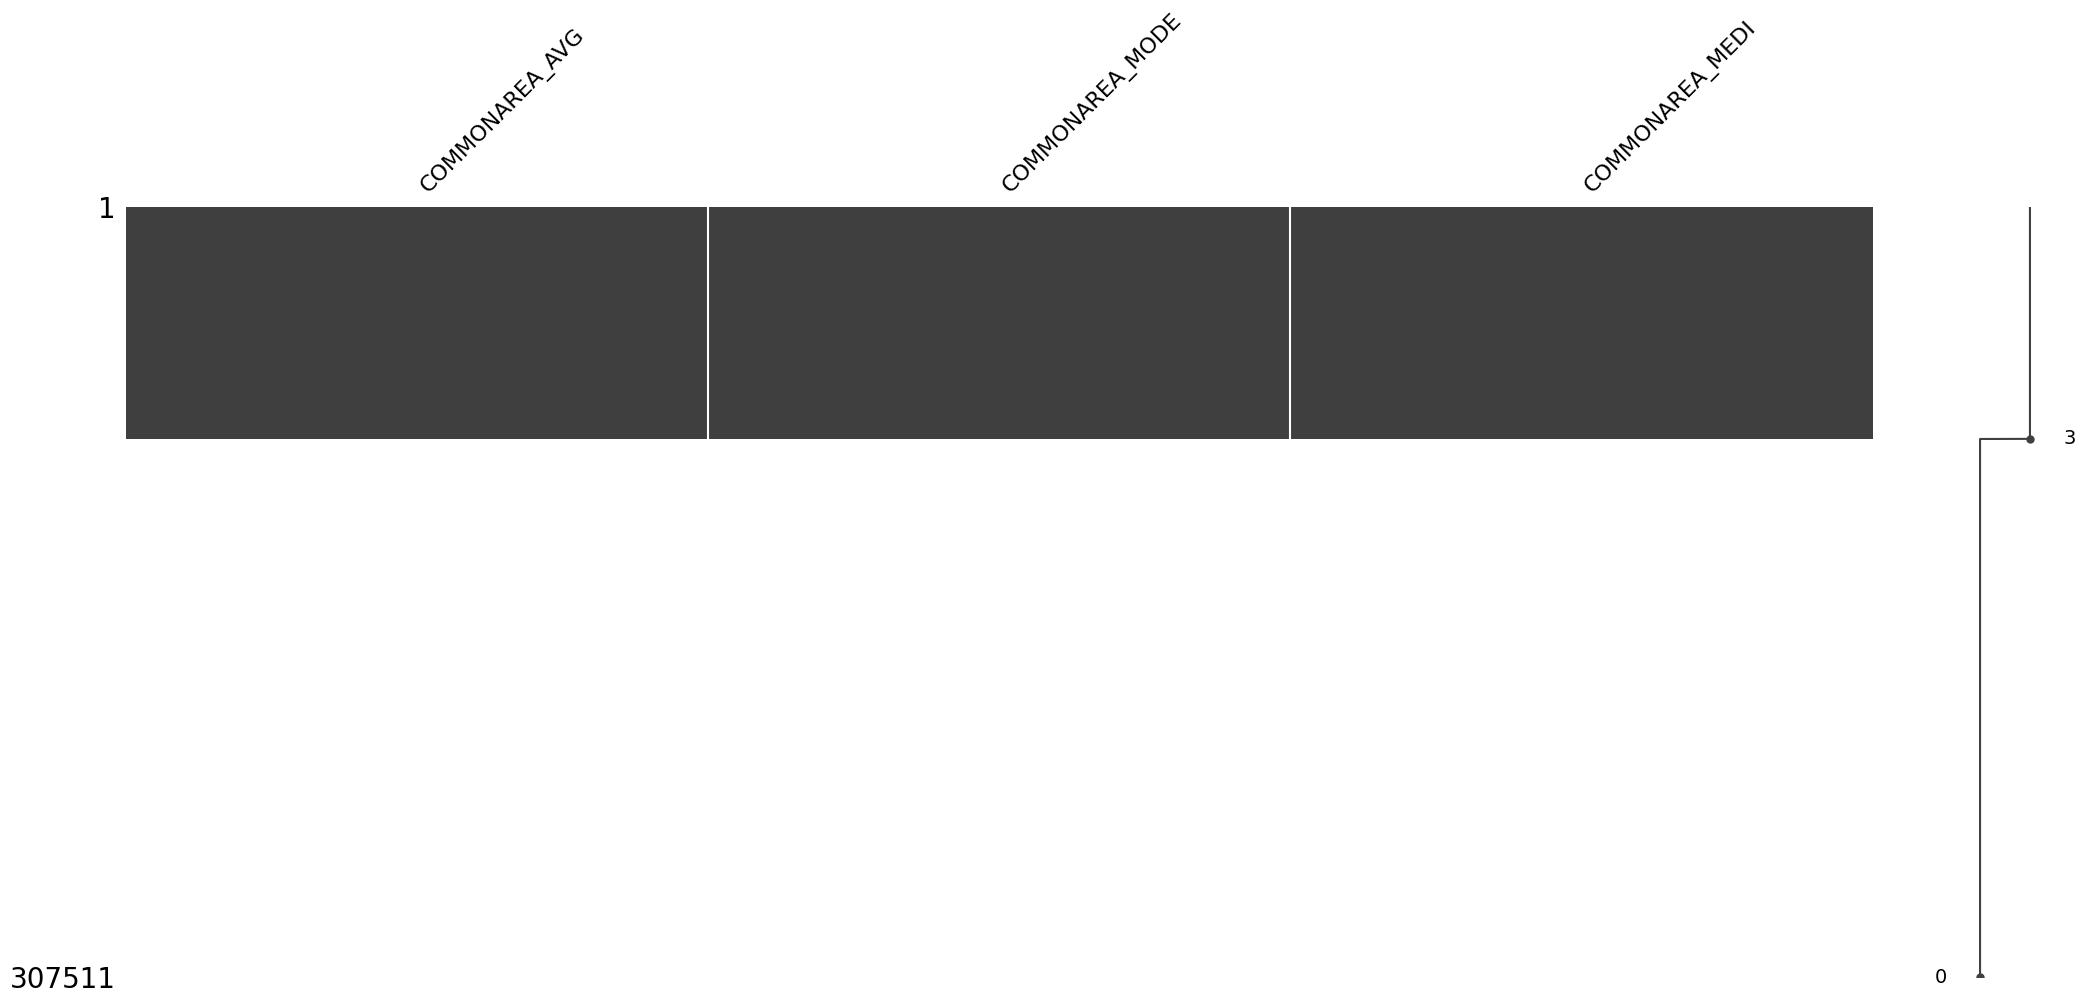

In [28]:
import missingno as msno
msno.matrix(train[[x for x in train.columns if 'COMMONAREA' in x]].sort_values(by = 'COMMONAREA_AVG'))

For Common area, 0 denotes no Common area

In [38]:
train[[x for x in train.columns if 'COMMONAREA' in x]] = train[[x for x in train.columns if 'COMMONAREA' in x]].fillna(0)

The same thing for the afterwards "house" feature

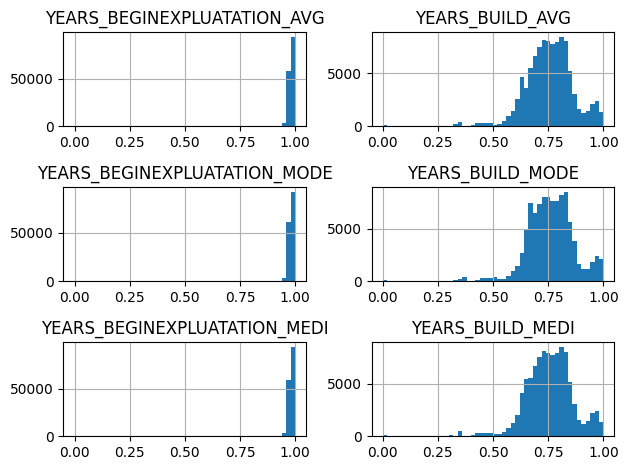

In [58]:
train[[x for x in train.columns if 'YEARS' in x]].hist(bins= 50)
plt.tight_layout()
plt.show()

<Axes: >

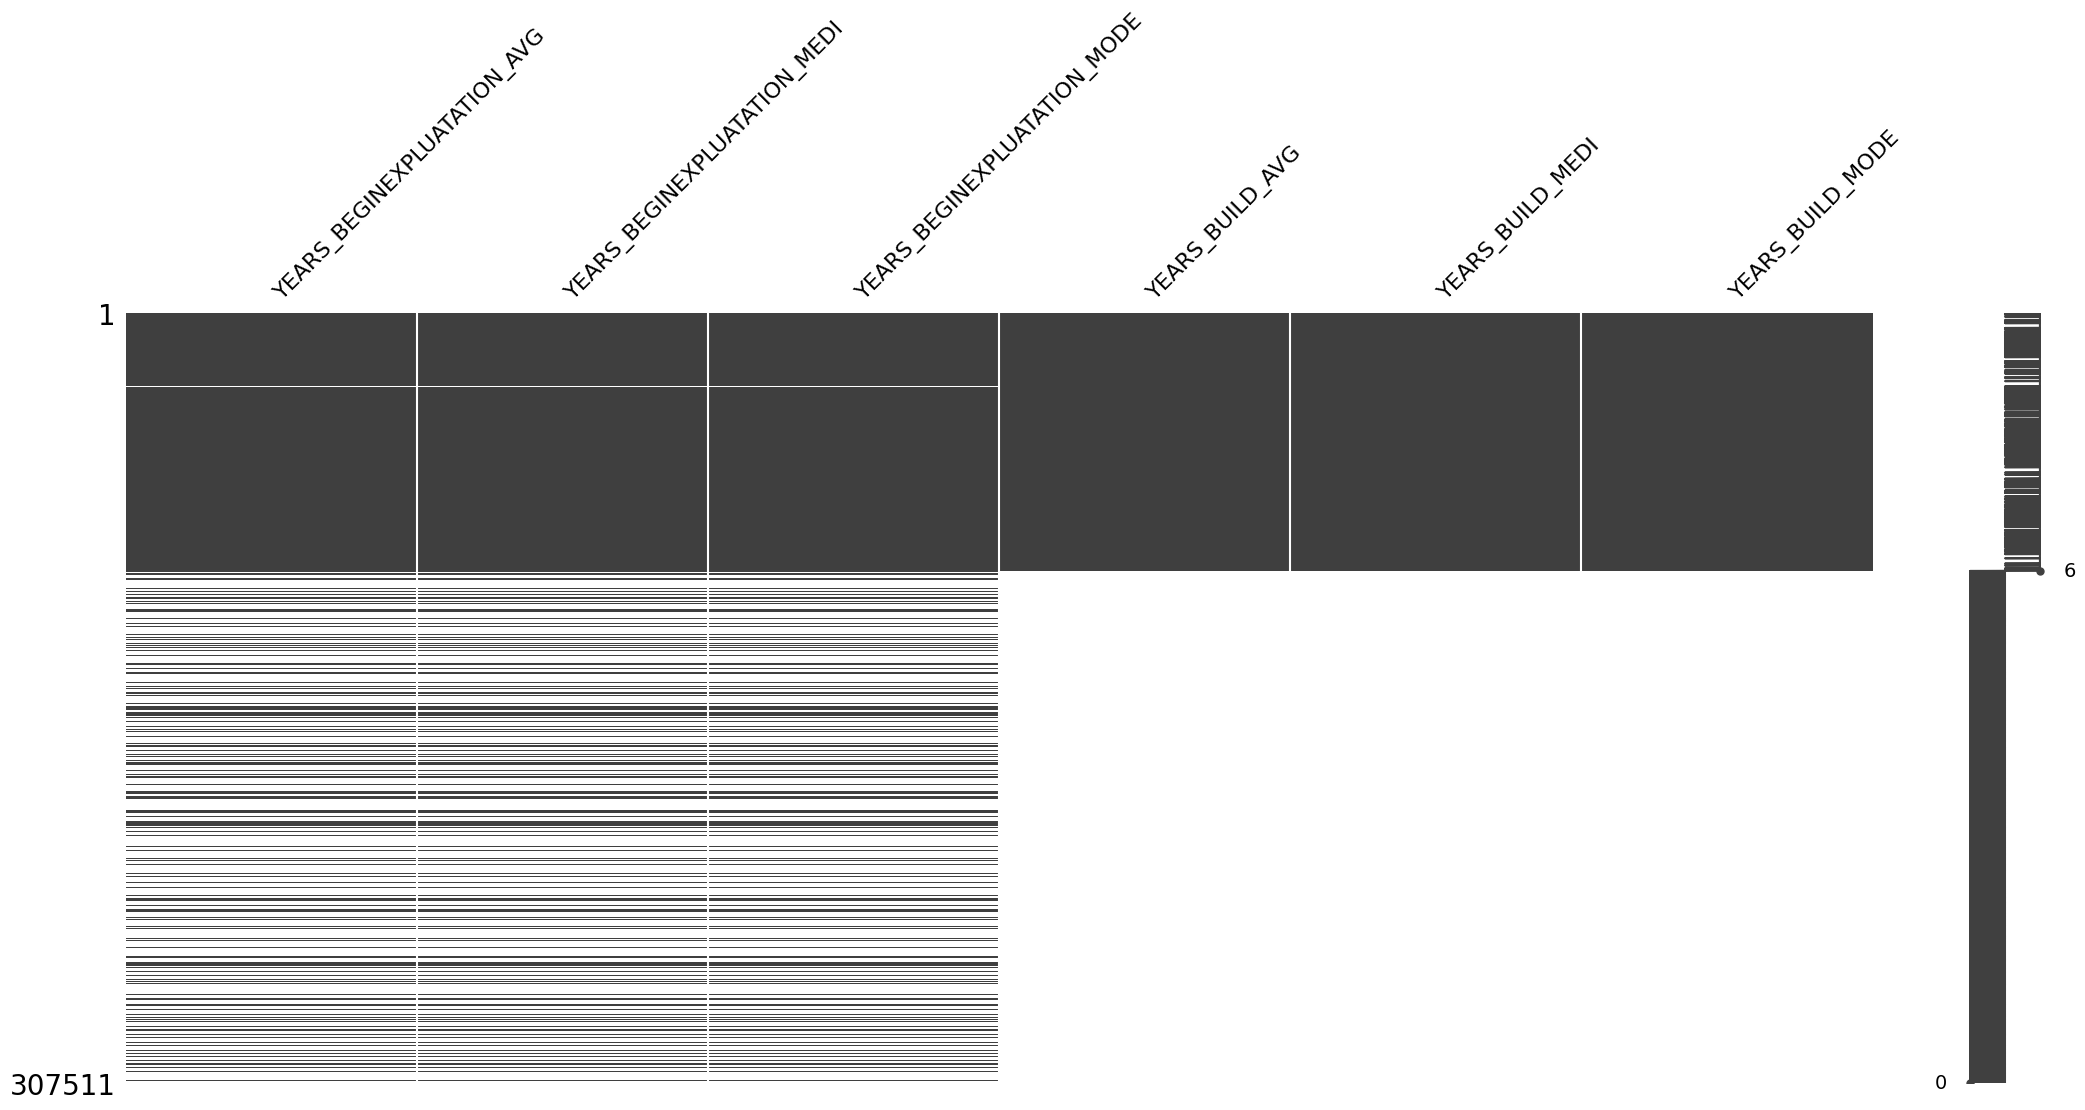

In [56]:
msno.matrix(train[sorted([x for x in train.columns if 'YEARS' in x])].sort_values(by = 'YEARS_BUILD_MEDI'))

In [64]:
train[[x for x in train.columns if 'YEARS' in x]] = train[[x for x in train.columns if 'YEARS' in x]].fillna(train[[x for x in train.columns if 'YEARS' in x]].mean())

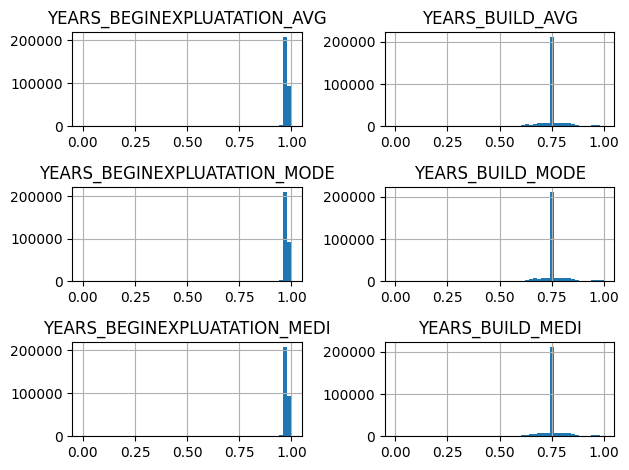

In [69]:
train[[x for x in train.columns if 'YEARS' in x]].hist(bins= 50)
plt.tight_layout()
plt.show()

In [70]:
train

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR   
0           100002       1         Cash loans           M            N  \
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT   
0                    Y             0          202500.0    406597.5  \
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20   
0           24700.5  ...                 0                0                0  \
1           35698.5  ...                 0                0                0   
2            6750.0  ...                 0                0                0   
3           29686.5  ...                 0                0                0   
4           21865.5  ...                 0                0                0   
...             ...  ...               ...              ...              ...   
307506      27558.0  ...                 0                0                0   
307507      12001.5  ...                 0                0                0   
307508      29979.0  ...                 0                0                0   
307509      20205.0  ...                 0                0                0   
307510      49117.5  ...                 0                0                0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY   
0                     0                        0.0                       0.0  \
1                     0                        0.0                       0.0   
2                     0                        0.0                       0.0   
3                     0                        NaN                       NaN   
4                     0                        0.0                       0.0   
...                 ...                        ...                       ...   
307506                0                        NaN                       NaN   
307507                0                        NaN                       NaN   
307508                0                        1.0                       0.0   
307509                0                        0.0                       0.0   
307510                0                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON   
0                              0.0                        0.0  \
1                              0.0                        0.0   
2                              0.0                        0.0   
3                              NaN                        NaN   
4                              

<Axes: >

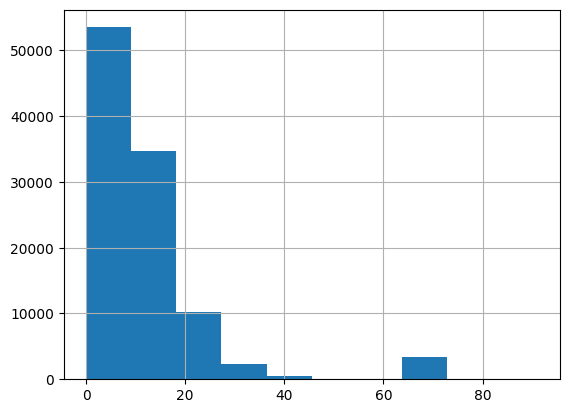

In [72]:
train['OWN_CAR_AGE'].hist()

In [75]:
train['OWN_CAR_AGE'].dropna().sort_values()

203189     0.0
266899     0.0
122543     0.0
78809      0.0
78826      0.0
          ... 
257137    65.0
83042     65.0
161390    69.0
294131    91.0
271741    91.0
Name: OWN_CAR_AGE, Length: 104582, dtype: float64

In [79]:
train[['OWN_CAR_AGE','FLAG_OWN_CAR']][train['FLAG_OWN_CAR'] == 'N']

OWN_CAR_AGE FLAG_OWN_CAR
0               NaN            N
1               NaN            N
3               NaN            N
4               NaN            N
5               NaN            N
...             ...          ...
307506          NaN            N
307507          NaN            N
307508          NaN            N
307509          NaN            N
307510          NaN            N

[202924 rows x 2 columns]

array([[<Axes: title={'center': 'EXT_SOURCE_1'}>,
        <Axes: title={'center': 'EXT_SOURCE_2'}>],
       [<Axes: title={'center': 'EXT_SOURCE_3'}>, <Axes: >]], dtype=object)

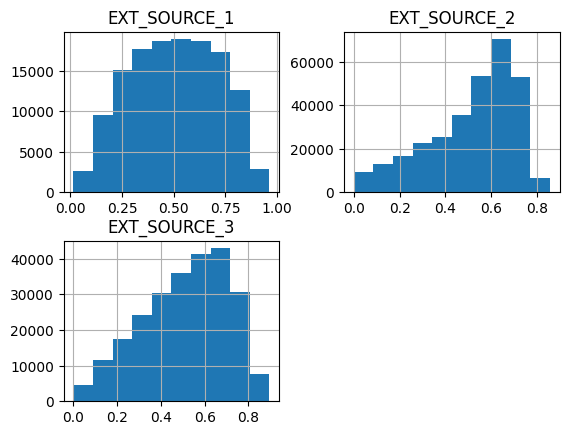

In [84]:
train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].hist()

In [88]:
train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']] = train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].fillna(train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].mean())

In [94]:
temp = train[Building_features].drop([x for x in train.columns if 'YEARS' in x],axis=1).fillna(0)
train[temp.columns] = temp
del temp

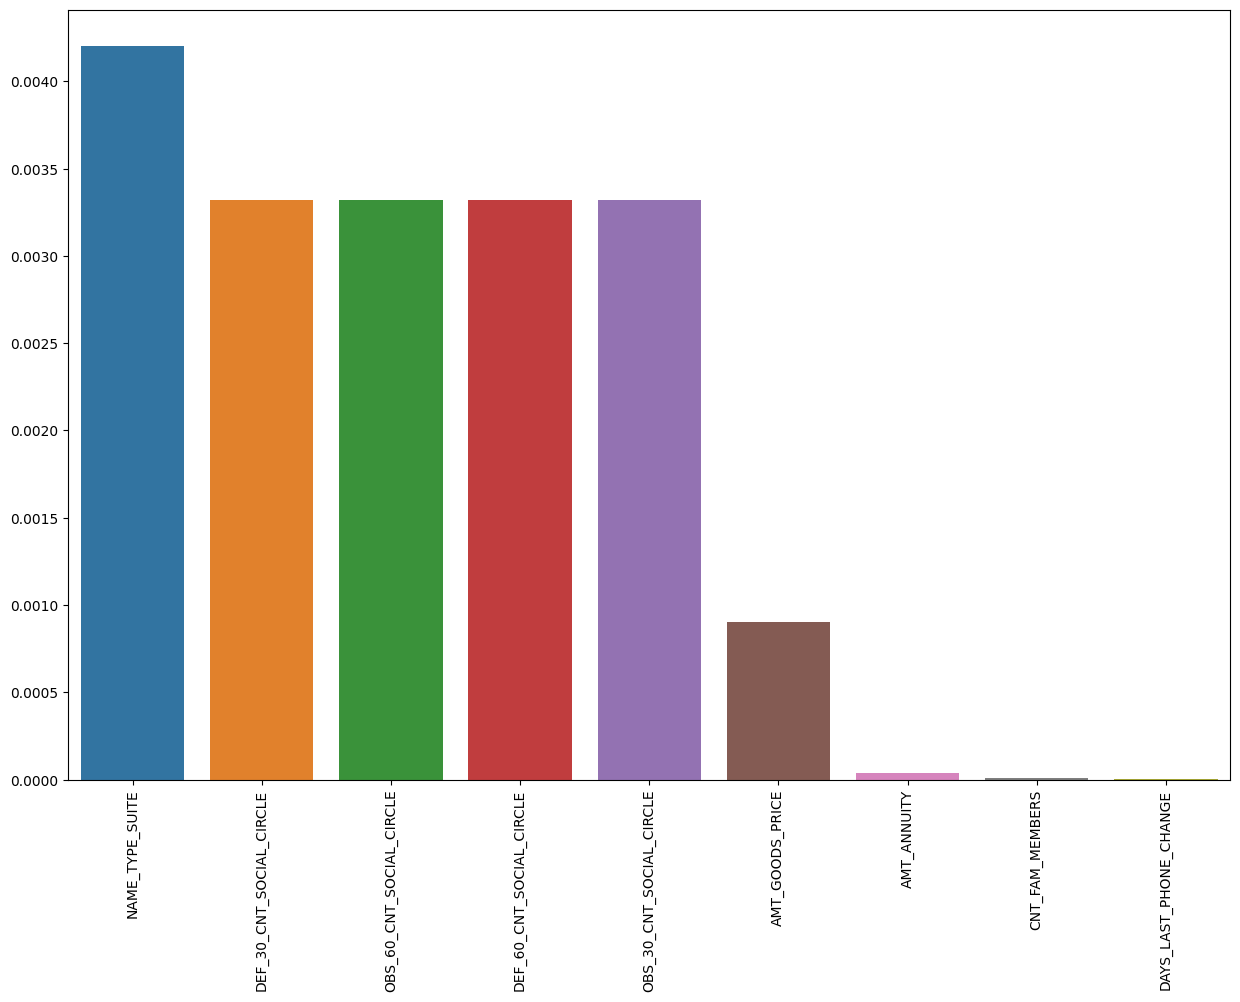

In [160]:
nacount = train.isna().sum().sort_values(ascending = False)/len(train)
nacount = nacount[nacount>0]
plt.figure(figsize = (15,10))
sns.barplot(x = nacount.index, y = nacount.values)
plt.xticks(rotation=90);

In [116]:
train['FONDKAPREMONT_MODE'].fillna(train['FONDKAPREMONT_MODE'].mode().values[0],inplace = True)

In [120]:
train['WALLSMATERIAL_MODE'].fillna(train['WALLSMATERIAL_MODE'].mode().values[0],inplace = True)

In [122]:
train['HOUSETYPE_MODE'].fillna(train['HOUSETYPE_MODE'].mode().values[0],inplace = True)

In [123]:
train['EMERGENCYSTATE_MODE'].fillna(train['EMERGENCYSTATE_MODE'].mode().values[0],inplace = True)

In [129]:
train.drop('OWN_CAR_AGE',axis=1).dropna()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR   
0           100002       1         Cash loans           M            N  \
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307502      456246       0         Cash loans           F            N   
307503      456247       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT   
0                    Y             0          202500.0    406597.5  \
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
4                    Y             0          121500.0    513000.0   
5                    Y             0           99000.0    490495.5   
...                ...           ...               ...         ...   
307502               Y             1           94500.0    225000.0   
307503               Y             0          112500.0    345510.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20   
0           24700.5  ...                 0                0                0  \
1           35698.5  ...                 0                0                0   
2            6750.0  ...                 0                0                0   
4           21865.5  ...                 0                0                0   
5           27517.5  ...                 0                0                0   
...             ...  ...               ...              ...              ...   
307502      10620.0  ...                 0                0                0   
307503      17770.5  ...                 0                0                0   
307508      29979.0  ...                 0                0                0   
307509      20205.0  ...                 0                0                0   
307510      49117.5  ...                 0                0                0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY   
0                     0                        0.0                       0.0  \
1                     0                        0.0                       0.0   
2                     0                        0.0                       0.0   
4                     0                        0.0                       0.0   
5                     0                        0.0                       0.0   
...                 ...                        ...                       ...   
307502                0                        0.0                       0.0   
307503                0                        0.0                       0.0   
307508                0                        1.0                       0.0   
307509                0                        0.0                       0.0   
307510                0                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON   
0                              0.0                        0.0  \
1                              0.0                        0.0   
2                              0.0                        0.0   
4                              0.0                        0.0   
5                              

In [130]:
train[[x for x in train.columns if "AMT_REQ" in x]]

AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY   
0                              0.0                        0.0  \
1                              0.0                        0.0   
2                              0.0                        0.0   
3                              NaN                        NaN   
4                              0.0                        0.0   
...                            ...                        ...   
307506                         NaN                        NaN   
307507                         NaN                        NaN   
307508                         1.0                        0.0   
307509                         0.0                        0.0   
307510                         0.0                        0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON   
0                              0.0                        0.0  \
1                              0.0                        0.0   
2                              0.0                        0.0   
3                              NaN                        NaN   
4                              0.0                        0.0   
...                            ...                        ...   
307506                         NaN                        NaN   
307507                         NaN                        NaN   
307508                         0.0                        1.0   
307509                         0.0                        0.0   
307510                         0.0                        2.0   

        AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                             0.0                         1.0  
1                             0.0                         0.0  
2                             0.0                         0.0  
3                             NaN                         NaN  
4                             0.0                         0.0  
...                           ...                         ...  
307506                        NaN                         NaN  
307507                        NaN                         NaN  
307508                        0.0                         1.0  
307509                        0.0                         0.0  
307510                        0.0                         1.0  

[307511 rows x 6 columns]

<Axes: >

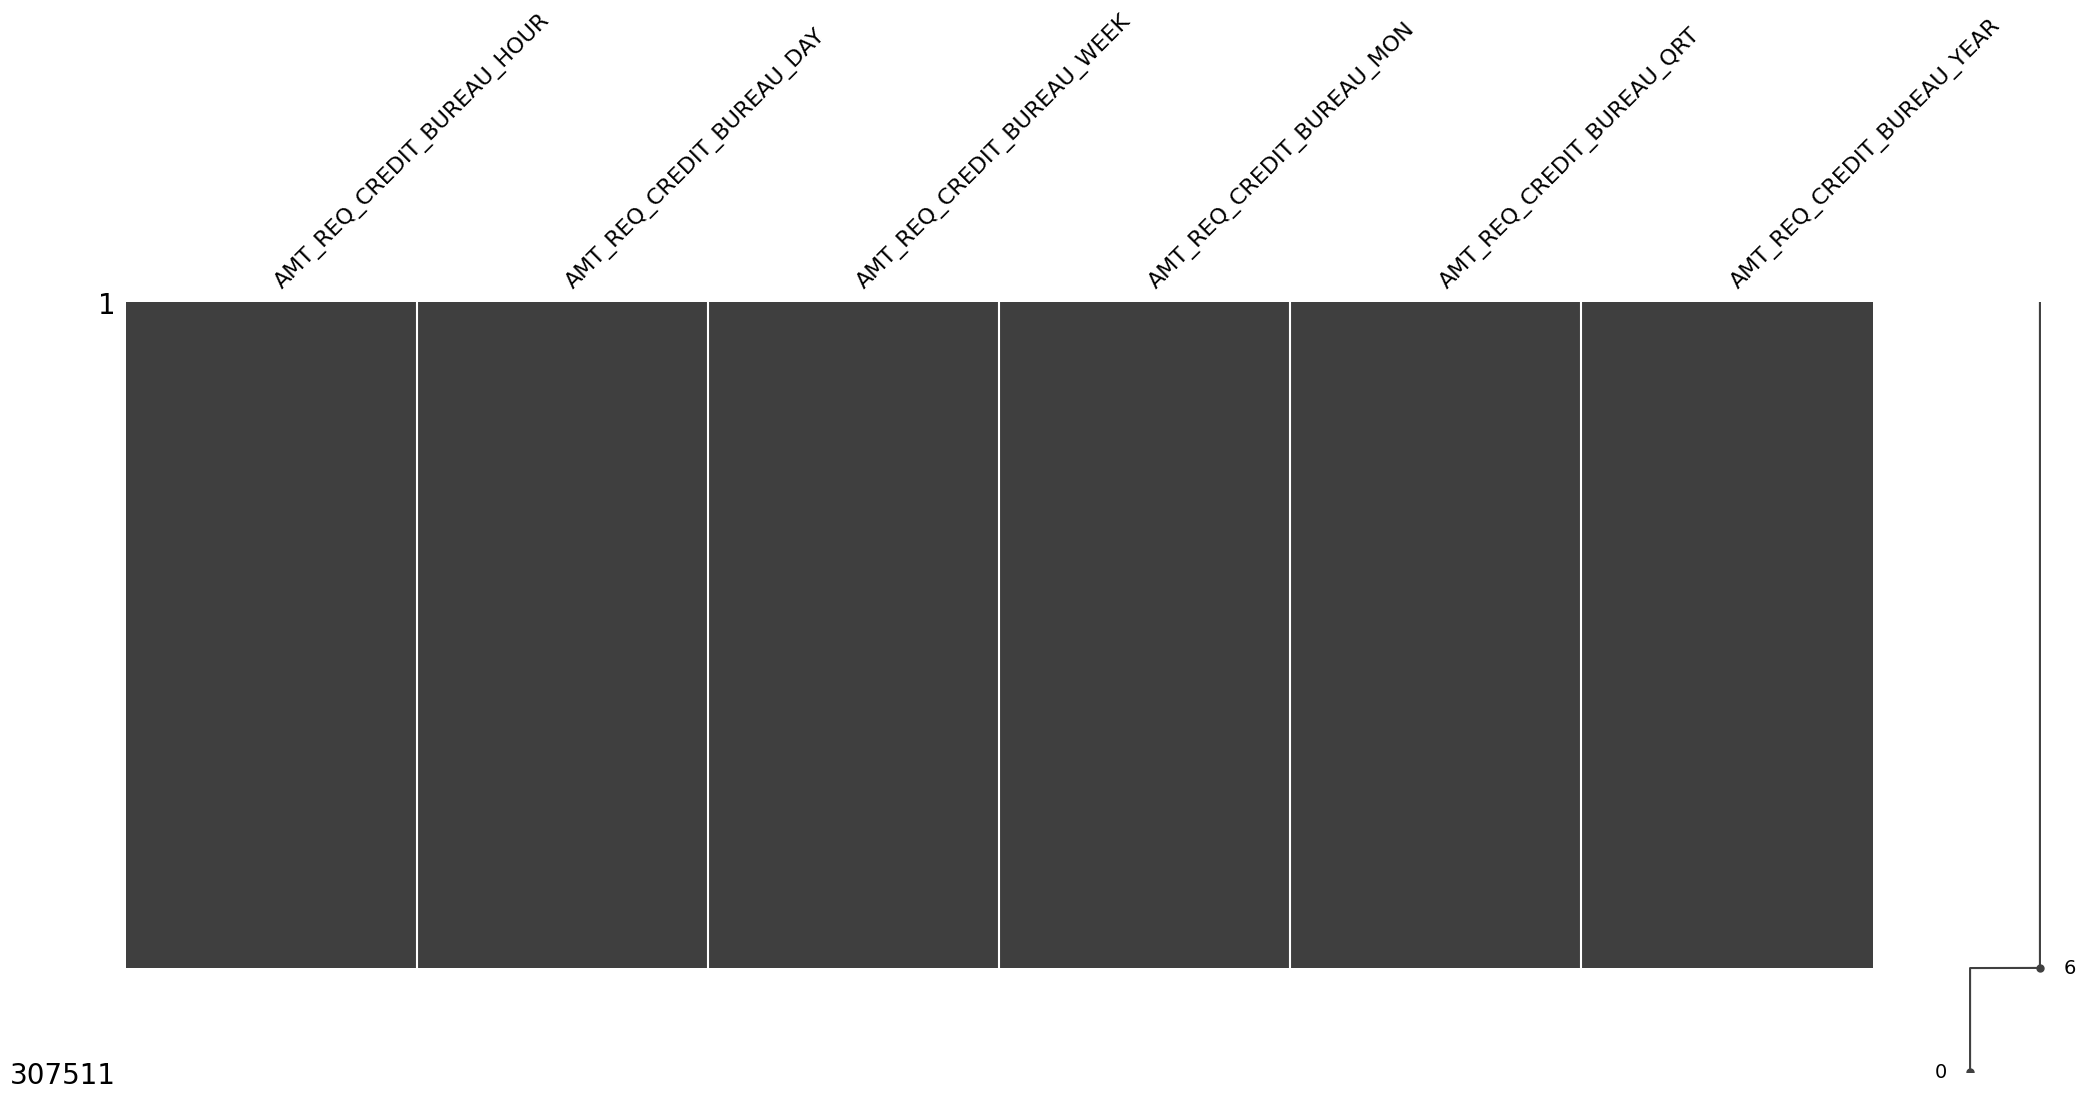

In [131]:
msno.matrix(train[[x for x in train.columns if "AMT_REQ" in x]].sort_values(by = 'AMT_REQ_CREDIT_BUREAU_HOUR'))

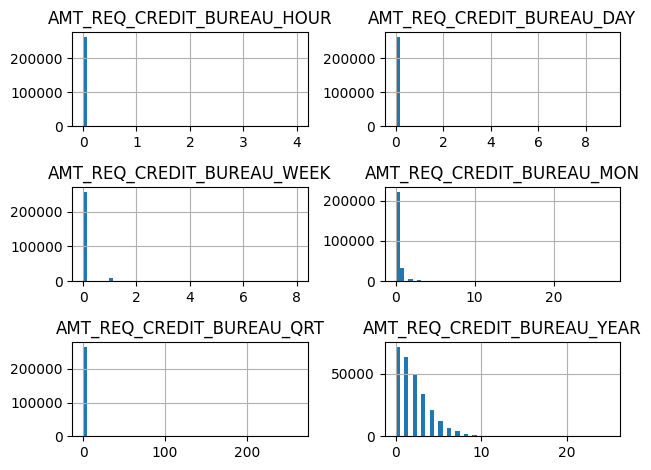

In [135]:
train[[x for x in train.columns if "AMT_REQ" in x]].hist(bins=50)
plt.tight_layout()
plt.show()

In [142]:
train[[x for x in train.columns if "AMT_REQ" in x]].fillna(train[[x for x in train.columns if "AMT_REQ" in x]].mode())

AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY   
0                              0.0                        0.0  \
1                              0.0                        0.0   
2                              0.0                        0.0   
3                              NaN                        NaN   
4                              0.0                        0.0   
...                            ...                        ...   
307506                         NaN                        NaN   
307507                         NaN                        NaN   
307508                         1.0                        0.0   
307509                         0.0                        0.0   
307510                         0.0                        0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON   
0                              0.0                        0.0  \
1                              0.0                        0.0   
2                              0.0                        0.0   
3                              NaN                        NaN   
4                              0.0                        0.0   
...                            ...                        ...   
307506                         NaN                        NaN   
307507                         NaN                        NaN   
307508                         0.0                        1.0   
307509                         0.0                        0.0   
307510                         0.0                        2.0   

        AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                             0.0                         1.0  
1                             0.0                         0.0  
2                             0.0                         0.0  
3                             NaN                         NaN  
4                             0.0                         0.0  
...                           ...                         ...  
307506                        NaN                         NaN  
307507                        NaN                         NaN  
307508                        0.0                         1.0  
307509                        0.0                         0.0  
307510                        0.0                         1.0  

[307511 rows x 6 columns]

In [147]:
for x in [x for x in train.columns if "AMT_REQ" in x]:
    train[x].fillna(train[x].mode().values[0],inplace = True)

In [146]:
x

'AMT_REQ_CREDIT_BUREAU_YEAR'

In [153]:
train["OCCUPATION_TYPE"].fillna("OTHERS",inplace = True)

In [158]:
train["OWN_CAR_AGE"].fillna(-999,inplace = True)

In [157]:
train['FLAG_OWN_CAR'].map({"Y":1,"N":0})

0         0
1         0
2         1
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    0
307510    0
Name: FLAG_OWN_CAR, Length: 307511, dtype: int64

In [162]:
train.dropna(inplace=True)

In [163]:
train

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR   
0           100002       1         Cash loans           M            N  \
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT   
0                    Y             0          202500.0    406597.5  \
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20   
0           24700.5  ...                 0                0                0  \
1           35698.5  ...                 0                0                0   
2            6750.0  ...                 0                0                0   
3           29686.5  ...                 0                0                0   
4           21865.5  ...                 0                0                0   
...             ...  ...               ...              ...              ...   
307506      27558.0  ...                 0                0                0   
307507      12001.5  ...                 0                0                0   
307508      29979.0  ...                 0                0                0   
307509      20205.0  ...                 0                0                0   
307510      49117.5  ...                 0                0                0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY   
0                     0                        0.0                       0.0  \
1                     0                        0.0                       0.0   
2                     0                        0.0                       0.0   
3                     0                        0.0                       0.0   
4                     0                        0.0                       0.0   
...                 ...                        ...                       ...   
307506                0                        0.0                       0.0   
307507                0                        0.0                       0.0   
307508                0                        1.0                       0.0   
307509                0                        0.0                       0.0   
307510                0                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON   
0                              0.0                        0.0  \
1                              0.0                        0.0   
2                              0.0                        0.0   
3                              0.0                        0.0   
4                              

In [165]:
object_train.nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [169]:
train.drop('ORGANIZATION_TYPE',axis=1,inplace = True)

In [170]:
pd.get_dummies(train,drop_first=True)

SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT   
0           100002       1             0          202500.0    406597.5  \
1           100003       0             0          270000.0   1293502.5   
2           100004       0             0           67500.0    135000.0   
3           100006       0             0          135000.0    312682.5   
4           100007       0             0          121500.0    513000.0   
...            ...     ...           ...               ...         ...   
307506      456251       0             0          157500.0    254700.0   
307507      456252       0             0           72000.0    269550.0   
307508      456253       0             0          153000.0    677664.0   
307509      456254       1             0          171000.0    370107.0   
307510      456255       0             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH   
0           24700.5         351000.0                    0.018801       -9461  \
1           35698.5        1129500.0                    0.003541      -16765   
2            6750.0         135000.0                    0.010032      -19046   
3           29686.5         297000.0                    0.008019      -19005   
4           21865.5         513000.0                    0.028663      -19932   
...             ...              ...                         ...         ...   
307506      27558.0         225000.0                    0.032561       -9327   
307507      12001.5         225000.0                    0.025164      -20775   
307508      29979.0         585000.0                    0.005002      -14966   
307509      20205.0         319500.0                    0.005313      -11961   
307510      49117.5         675000.0                    0.046220      -16856   

        DAYS_EMPLOYED  ...  FONDKAPREMONT_MODE_reg oper spec account   
0                -637  ...                                     False  \
1               -1188  ...                                     False   
2                -225  ...                                     False   
3               -3039  ...                                     False   
4               -3038  ...                                     False   
...               ...  ...                                       ...   
307506           -236  ...                                     False   
307507         365243  ...                                     False   
307508          -7921  ...                                     False   
307509          -4786  ...                                     False   
307510          -1262  ...                                     False   

        HOUSETYPE_MODE_specific housing  HOUSETYPE_MODE_terraced house   
0                                 False                          False  \
1                                 False                          False   
2                                 False                          False   
3                                 False                          False   
4                                 False                          False   
...                                 ...                            ...   
307506                            False                          False   
307507                            False                          False   
307508                            False                          False   
307509                            False                          False   
307510                            False                          False   

        WALLSMATERIAL_MODE_Mixed  WALLSMATERIAL_MODE_Monolithic   
0                          False                          False  \
1                          False                          False   
2                          False                          False   
3                          False                          False   
4                          False                          False   
..

In [174]:
train = train.drop('SK_ID_CURR',axis=1)

In [171]:
train = pd.get_dummies(train,drop_first=True)

In [175]:
X_train = train.drop('TARGET',axis= 1)
y_train = train['TARGET']

In [179]:
import pandas as pd
import urllib
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from bayes_opt import BayesianOptimization
import time
from urllib.request import urlretrieve

def xgb_cv(max_depth, learning_rate, subsample, colsample_bytree):

    params = {'objective': 'binary:logistic',
              'max_depth': int(max_depth),
              'learning_rate': learning_rate,
              'subsample': subsample,
              'colsample_bytree': colsample_bytree}
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    cv_result = xgb.cv(params, dtrain, num_boost_round=100, early_stopping_rounds=10, nfold=5, metrics='error')
    return -cv_result['test-error-mean'].iloc[-1]

pbounds = {'max_depth': (3, 10),
           'learning_rate': (0.01, 0.5),
           'subsample': (0.1, 1),
           'colsample_bytree': (0.1, 1)}

print('Performing hyperparameter tuning using Bayesian optimization...')
optimizer = BayesianOptimization(f=xgb_cv, pbounds=pbounds, random_state=1)
optimizer.maximize(init_points=5, n_iter=40)

print('Training the XGBoost model with the best hyperparameters from Bayesian optimization...')

params = {'objective': 'binary:logistic',
          'max_depth': int(optimizer.max['params']['max_depth']),
          'learning_rate': optimizer.max['params']['learning_rate'],
          'subsample': optimizer.max['params']['subsample'],
          'colsample_bytree':optimizer.max['params']['colsample_bytree']}
          
print('Making predictions on the test set...')

xgb_model = xgb.XGBClassifier(**params)
xgb_model.fit(X_train,y_train)

# dtest = xgb.DMatrix(X_test)
y_pred = xgb_model.predict(X_test)
# y_pred = [int(round(value)) for value in y_pred]

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy * 100.0))

Performing hyperparameter tuning using Bayesian optimization...
|   iter    |  target   | colsam... | learni... | max_depth | subsample |
-------------------------------------------------------------------------
| 1         | -0.081    | 0.4753    | 0.363     | 3.001     | 0.3721    |
| 2         | -0.081    | 0.2321    | 0.05525   | 4.304     | 0.411     |
| 3         | -0.0807   | 0.4571    | 0.274     | 5.934     | 0.7167    |
| 4         | -0.08079  | 0.284     | 0.4403    | 3.192     | 0.7034    |
| 5         | -0.08086  | 0.4756    | 0.2838    | 3.983     | 0.2783    |
| 6         | -0.081    | 0.1069    | 0.08931   | 7.966     | 0.7883    |
| 7         | -0.08075  | 0.4983    | 0.2126    | 6.835     | 0.7698    |
| 8         | -0.08074  | 0.661     | 0.1194    | 9.714     | 0.8242    |
| 9         | -0.08098  | 0.1191    | 0.4059    | 9.754     | 0.7319    |
| 10        | -0.081    | 0.428     | 0.02098   | 4.067     | 0.9744    |
| 11        | -0.08127  | 0.9958    | 0.1693    


KeyboardInterrupt



In [198]:
# Set class weights
class_weights = {0: 1, 1: 10}  # Class 0: 1, Class 1: 10

# Set "scale_pos_weight" based on class balance
pos_weight = sum(class_weights.values()) / sum(class_weights.keys())

# Train XGBoost model
model = xgb.XGBClassifier(scale_pos_weight=pos_weight)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
# y_pred = [int(round(value)) for value in y_pred]

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy * 100.0))

recall = recall_score(y_test, y_pred,pos_label = 1)

print('Recall:%.2f%%' % (recall * 100.0))

NameError: name 'X_test' is not defined

In [199]:
y_pred = model.predict(X_train)

In [200]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report


accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %.2f%%' % (accuracy * 100.0))

recall = recall_score(y_train, y_pred,pos_label = 1)

print('Recall:%.2f%%' % (recall * 100.0))

Accuracy: 75.50%
Recall:76.82%


In [196]:
np.sum(y_pred == 1)/len(y_pred)

0.8011402919540607

In [197]:
np.sum(y_train == 1)/len(y_train)

0.08099677244949785

In [3]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


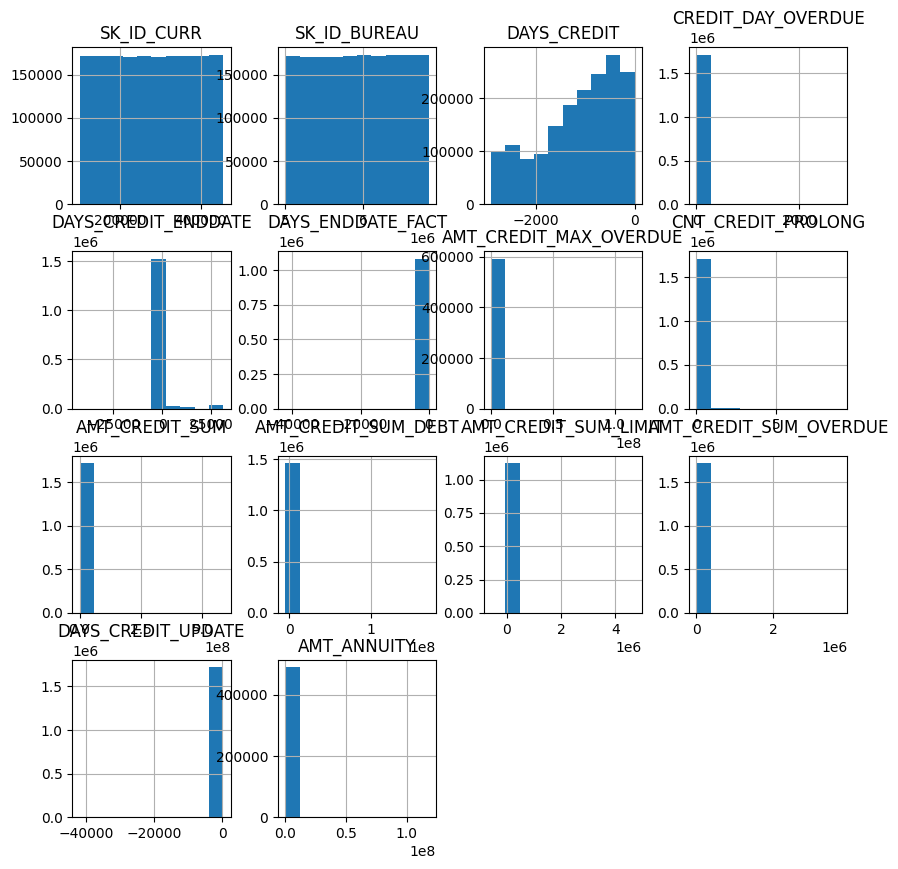

In [5]:
bureau.hist(figsize = (10,10))
plt.show()

In [6]:
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

SK_ID_CURR  previous_loan_counts
0      100001                     7
1      100002                     8
2      100003                     4
3      100004                     2
4      100005                     3

In [45]:
bureau_features = bureau[numeric_train.columns.difference(['SK_ID_BUREAU'])].groupby('SK_ID_CURR').agg(['min','max','mean','std'])

# Add suffixes to the column names
bureau_features.columns = ['_'.join(col).strip() for col in bureau_features.columns.values]

bureau_features = bureau_features.reset_index()


In [50]:
credit_card_balance['NAME_CONTRACT_STATUS'].value_counts()

NAME_CONTRACT_STATUS
Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: count, dtype: int64

In [56]:
credit_card_balance = pd.get_dummies(credit_card_balance,drop_first=True)

In [74]:
# Aggregating the dummy variables (count)
dummy_cols = [col for col in credit_card_balance.columns if 'NAME_CONTRACT_STATUS' in col]
agg_dummies = credit_card_balance.groupby('SK_ID_CURR')[dummy_cols].agg('sum')

# Aggregating other variables (min, max, mean, std, count)
other_cols = credit_card_balance.columns.difference(dummy_cols + ['SK_ID_CURR'])
agg_others = credit_card_balance.groupby('SK_ID_CURR')[other_cols].agg(['min', 'max', 'mean', 'std'])

# Flatten the multi-level column index for 'agg_others'
agg_others.columns = ['_'.join(col).strip() for col in agg_others.columns.values]

# Merge the two DataFrames
final_agg = pd.merge(agg_others, agg_dummies, on='SK_ID_CURR', how='left')


In [75]:
final_agg

AMT_BALANCE_min  AMT_BALANCE_max  AMT_BALANCE_mean   
SK_ID_CURR                                                       
100006                0.000            0.000          0.000000  \
100011                0.000       189000.000      54482.111149   
100013                0.000       161420.220      18159.919219   
100021                0.000            0.000          0.000000   
100023                0.000            0.000          0.000000   
...                     ...              ...               ...   
456244                0.000       453627.675     131834.730732   
456246                0.000        43490.115      13136.731875   
456247                0.000       190202.130      23216.396211   
456248                0.000            0.000          0.000000   
456250           153832.725       200208.915     173589.326250   

            AMT_BALANCE_std  AMT_CREDIT_LIMIT_ACTUAL_min   
SK_ID_CURR                                                 
100006             0.000000                       270000  \
100011         68127.238270                        90000   
100013         43237.406997                        45000   
100021             0.000000                       675000   
100023             0.000000                        45000   
...                     ...                          ...   
456244        181540.706436                            0   
456246         18263.381378                       135000   
456247         56576.242229                            0   
456248             0.000000                       900000   
456250         12914.006678                       175500   

            AMT_CREDIT_LIMIT_ACTUAL_max  AMT_CREDIT_LIMIT_ACTUAL_mean   
SK_ID_CURR                                                              
100006                           270000                 270000.000000  \
100011                           180000                 164189.189189   
100013                           157500                 131718.750000   
100021                           675000                 675000.000000   
100023                           225000                 135000.000000   
...                                 ...                           ...   
456244                           450000                 296341.463415   
456246                           135000                 135000.000000   
456247                           180000                 144000.000000   
456248                           900000                 900000.000000   
456250                           180000                 178875.000000   

            AMT_CREDIT_LIMIT_ACTUAL_std  AMT_DRAWINGS_ATM_CURRENT_min   
SK_ID_CURR                                                              
100006                         0.000000                           NaN  \
100011                     34482.743620                           0.0   
100013                     47531.585759                           0.0   
100021                         0.000000                           NaN   
100023                     96214.047088                           NaN   
...                                 ...                           ...   
456244                    216041.154616                           0.0   
456246                         0.000000                           0.0   
456247                     72381.965545                           0.0   
456248                         0.000000                           NaN   
456250                      2035.201576                           0.0   

            AMT_DRAWINGS_ATM_CURRENT_max  ...  SK_ID_PREV_min  SK_ID_PREV_max   
SK_ID_CURR                                ...                                   
100006                               NaN  ...         1489396         1489396  \
100011                          180000.0  ...         1843384         1843384   
100013                          157500.0  ...         2038692         2038692   
100021                               NaN  ...         2594025      

In [ ]:
final_agg.columns = ['bureau_' + col for col in final_agg.columns]

In [ ]:
def agg_numeric(df, group_var, df_name):
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
    agg.columns = columns
    return agg

In [17]:
numeric_train = bureau.select_dtypes(include=[np.number])
object_train = bureau.select_dtypes(include=[object])

array([[<Axes: title={'center': 'SK_ID_CURR'}>,
        <Axes: title={'center': 'SK_ID_BUREAU'}>,
        <Axes: title={'center': 'DAYS_CREDIT'}>,
        <Axes: title={'center': 'CREDIT_DAY_OVERDUE'}>],
       [<Axes: title={'center': 'DAYS_CREDIT_ENDDATE'}>,
        <Axes: title={'center': 'DAYS_ENDDATE_FACT'}>,
        <Axes: title={'center': 'AMT_CREDIT_MAX_OVERDUE'}>,
        <Axes: title={'center': 'CNT_CREDIT_PROLONG'}>],
       [<Axes: title={'center': 'AMT_CREDIT_SUM'}>,
        <Axes: title={'center': 'AMT_CREDIT_SUM_DEBT'}>,
        <Axes: title={'center': 'AMT_CREDIT_SUM_LIMIT'}>,
        <Axes: title={'center': 'AMT_CREDIT_SUM_OVERDUE'}>],
       [<Axes: title={'center': 'DAYS_CREDIT_UPDATE'}>,
        <Axes: title={'center': 'AMT_ANNUITY'}>, <Axes: >, <Axes: >]],
      dtype=object)

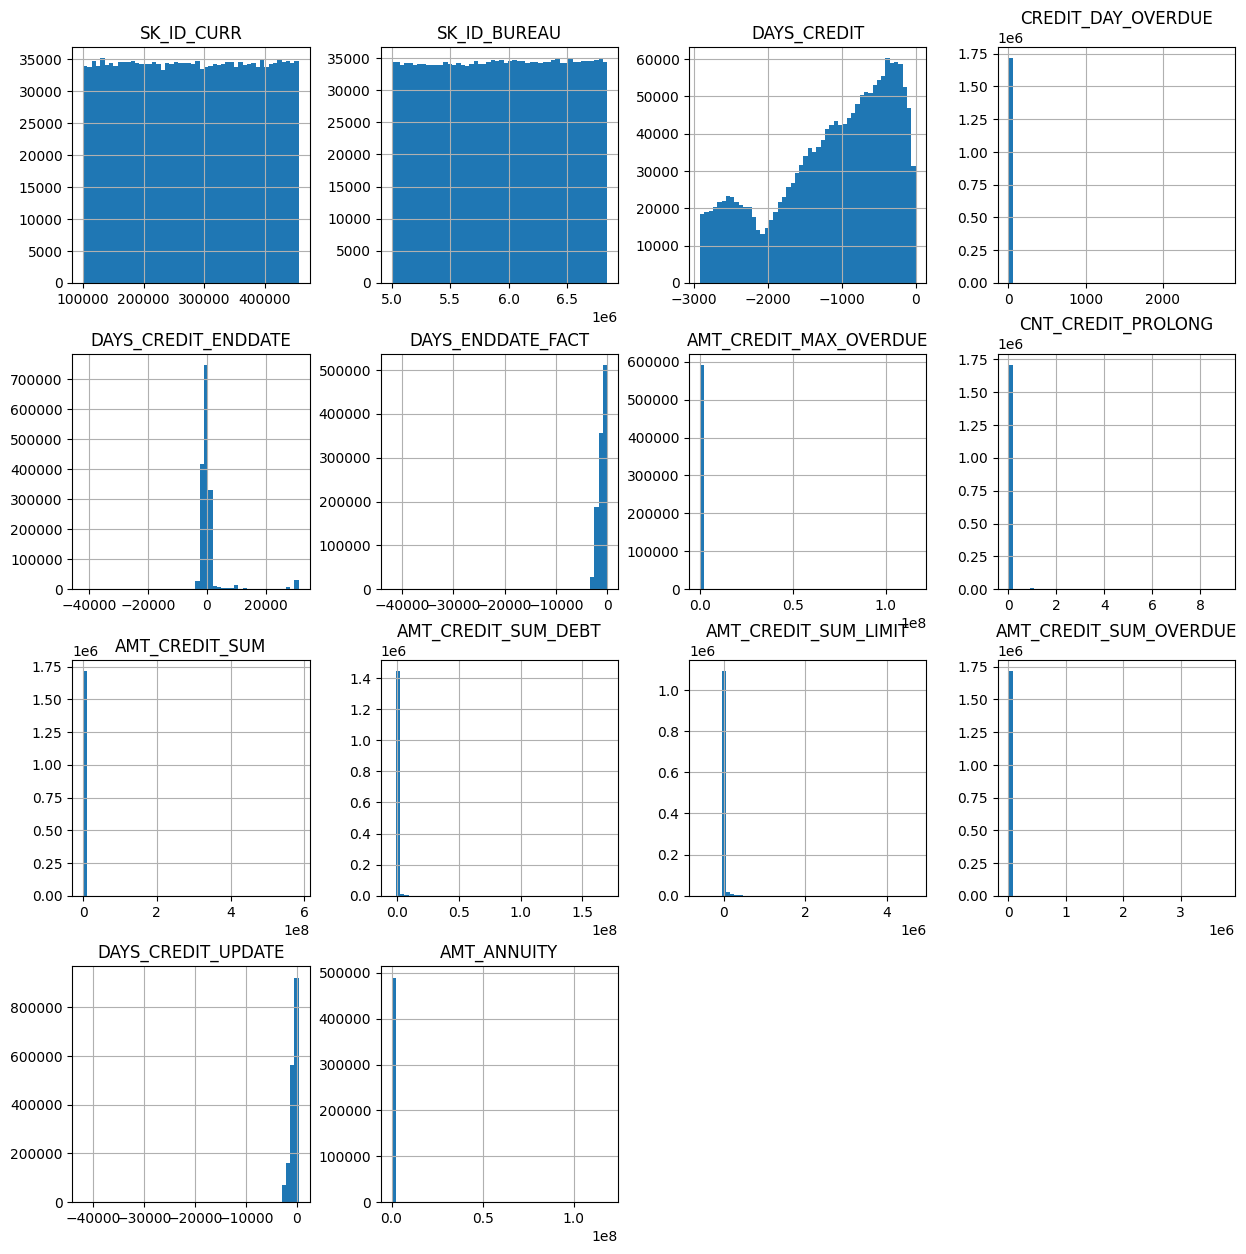

In [19]:
numeric_train.hist(bins = 50,figsize = (15,15))

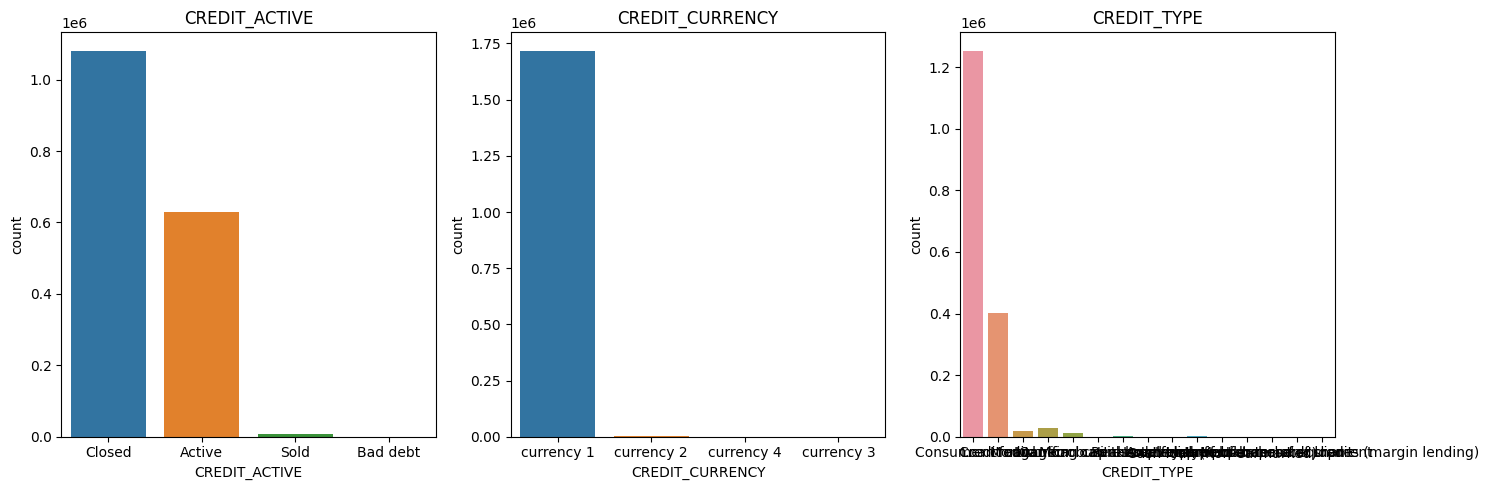

In [21]:
f, axes = plt.subplots(nrows = 1, ncols=3, figsize=(15,5))
axess = axes.flatten()

i = 0
for column in object_train.columns:
    sns.countplot(x = column,data = object_train, ax=axess[i])
    axess[i].set_title(column)
    i+=1

    
plt.tight_layout()
plt.show()

In [6]:
train

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR   
0           100002       1         Cash loans           M            N  \
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT   
0                    Y             0          202500.0    406597.5  \
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20   
0           24700.5  ...                 0                0                0  \
1           35698.5  ...                 0                0                0   
2            6750.0  ...                 0                0                0   
3           29686.5  ...                 0                0                0   
4           21865.5  ...                 0                0                0   
...             ...  ...               ...              ...              ...   
307506      27558.0  ...                 0                0                0   
307507      12001.5  ...                 0                0                0   
307508      29979.0  ...                 0                0                0   
307509      20205.0  ...                 0                0                0   
307510      49117.5  ...                 0                0                0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY   
0                     0                        0.0                       0.0  \
1                     0                        0.0                       0.0   
2                     0                        0.0                       0.0   
3                     0                        NaN                       NaN   
4                     0                        0.0                       0.0   
...                 ...                        ...                       ...   
307506                0                        NaN                       NaN   
307507                0                        NaN                       NaN   
307508                0                        1.0                       0.0   
307509                0                        0.0                       0.0   
307510                0                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON   
0                              0.0                        0.0  \
1                              0.0                        0.0   
2                              0.0                        0.0   
3                              NaN                        NaN   
4                              

In [13]:
pd.concat([bureau,train],keys = 'SK_ID_CURR',axis=1,join = 'inner').droplevel(0,axis=1)

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT   
0           215354       5714462        Closed      currency 1         -497  \
1           215354       5714463        Active      currency 1         -208   
2           215354       5714464        Active      currency 1         -203   
3           215354       5714465        Active      currency 1         -203   
4           215354       5714466        Active      currency 1         -629   
...            ...           ...           ...             ...          ...   
307506      251450       5855665        Active      currency 1         -147   
307507      251450       5855666        Closed      currency 1        -1378   
307508      251450       5855667        Closed      currency 1        -2178   
307509      251450       5855668        Closed      currency 1        -1189   
307510      251450       5855669        Closed      currency 1        -1140   

        CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT   
0                        0               -153.0             -153.0  \
1                        0               1075.0                NaN   
2                        0                528.0                NaN   
3                        0                  NaN                NaN   
4                        0               1197.0                NaN   
...                    ...                  ...                ...   
307506                   0               1679.0                NaN   
307507                   0              -1227.0            -1226.0   
307508                   0              -1966.0            -1966.0   
307509                   0                638.0             -833.0   
307510                   0               9818.0             -651.0   

        AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  ...  FLAG_DOCUMENT_18   
0                          NaN                   0  ...                 0  \
1                          NaN                   0  ...                 0   
2                          NaN                   0  ...                 0   
3                          NaN                   0  ...                 0   
4                      77674.5                   0  ...                 0   
...                        ...                 ...  ...               ...   
307506                     NaN                   0  ...                 0   
307507                     NaN                   0  ...                 0   
307508                     0.0                   0  ...                 0   
307509                     0.0                   0  ...                 0   
307510                     0.0                   1  ...                 0   

        FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21   
0                      0                 0                 0  \
1                      0                 0                 0   
2                      0                 0                 0   
3                      0                 0                 0   
4                      0                 0                 0   
...                  ...               ...               ...   
307506                 0                 0                 0   
307507                 0                 0                 0   
307508                 0                 0                 0   
307509                 0                 0                 0   
307510                 0                 0                 0   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY   
0                             0.0                        0.0  \
1                             0.0                        0.0   
2                             0.0                        0.0   
3                             NaN                        NaN   
4                             0.0                        0.0   
...                           ...                        ...   
307506                        NaN                        NaN   
307507      

In [ ]:
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [18]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
imputer.fit(train)
imputer.transform(train)

array([[1.00002e+05, 0.00000e+00, 2.02500e+05, ..., 1.00000e+00,
        0.00000e+00, 1.00000e+00],
       [1.00003e+05, 0.00000e+00, 2.70000e+05, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00004e+05, 0.00000e+00, 6.75000e+04, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [4.56253e+05, 0.00000e+00, 1.53000e+05, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [4.56254e+05, 0.00000e+00, 1.71000e+05, ..., 1.00000e+00,
        0.00000e+00, 1.00000e+00],
       [4.56255e+05, 0.00000e+00, 1.57500e+05, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [ ]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'num_leaves': hp.choice('num_leaves', range(20, 150, 5)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'max_depth': hp.choice('max_depth', range(5, 16, 1)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'min_split_gain': hp.uniform('min_split_gain', 0.01, 0.1),
    'min_child_weight': hp.uniform('min_child_weight', 10, 50),
    # ... include other parameters as needed
}

def objective(params, train_df, categorical_feature, num_folds, stratified=True):
    # ... [rest of the kfold_lightgbm function code, with clf params replaced by 'params']
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
#     sub_preds = np.zeros(test_df.shape[0])
#     feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(**params)
#         clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
#             eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)
        
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='auc', verbose=400, early_stopping_rounds=200,
                    feature_name= feats, categorical_feature= categorical_feature)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
#         sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

#         fold_importance_df = pd.DataFrame()
#         fold_importance_df["feature"] = feats
#         fold_importance_df["importance"] = clf.feature_importances_
#         fold_importance_df["fold"] = n_fold + 1
#         feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
#         print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
#         del clf, train_x, train_y, valid_x, valid_y
#         gc.collect()

    return {'loss': -roc_auc_score(train_df['TARGET'], oof_preds), 'status': STATUS_OK}

# Example usage
best = fmin(fn=lambda params: objective(params, train, list(train.select_dtypes(object).columns), 5),
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=Trials())


 50%|████    | 50/100 [29:54<27:10, 32.61s/trial, best loss: -0.759323127439005]

In [ ]:
le = 

In [36]:
list(train.select_dtypes(object).columns)

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [25]:
train.drop('TARGET',axis=1).columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=121)

In [28]:
import os
import gc
import time
import numpy as np
import pandas as pd
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings

In [38]:
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train:
    if train[col].dtype == 'object':
        # If 2 or fewer unique categories
            # Transform both training and testing data
            train[col] = le.fit_transform(train[col])
            test[col] = le.transform(test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1